# Variability due to dynamical or property change?
redid equation to include cross term

In [4]:
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import matplotlib.lines as mlines
from scipy.stats import pearsonr

## Functions

In [5]:
########
# MATH #
########

def decomp(data,base):
    # slight variation in euation from other attribution file
    # not dividing by transport - so looking at flux of a property instead of just mean property change
    d = {'section':['salish','cuc', 'off_d', 'off_s', 'north', 'south', 'fresh','loop'],
        'saltP':np.zeros(8),'saltQ':np.zeros(8),'saltX':np.zeros(8),'saltSUM':np.zeros(8),
        'tempP':np.zeros(8),'tempQ':np.zeros(8),'tempX':np.zeros(8),'tempSUM':np.zeros(8),
        'DOP':np.zeros(8),'DOQ':np.zeros(8),'DOX':np.zeros(8),'DOSUM':np.zeros(8),
        'NO3P':np.zeros(8),'NO3Q':np.zeros(8),'NO3X':np.zeros(8),'NO3SUM':np.zeros(8),
        'densP':np.zeros(8),'densQ':np.zeros(8),'densX':np.zeros(8),'densSUM':np.zeros(8),
        'TADICP':np.zeros(8),'TADICQ':np.zeros(8),'TADICX':np.zeros(8),'TADICSUM':np.zeros(8)}
    df = pd.DataFrame(d)

    # salt
    df['saltP'] = (data.salt[1:] - base.salt[1:])*(base.transport[1:])
    for i in range(7):
        if data.transport[i+1]>0:
            df.loc[i+1, "saltQ"] = ((data.transport[i+1]) - (base.transport[i+1]))*base['salt'][i+1]
        else:
            df.loc[i+1, "saltQ"]  = np.nan
    df['saltX'] = (data.salt[1:]-base.salt[1:])*(data.transport[1:]-base.transport[1:])
    df['saltSUM'] = df.saltP + df.saltQ

    # temp
    df['tempP'] = (data.temp[1:] - base.temp[1:])*(base.transport[1:])
    for i in range(7):
        if data.transport[i+1]>0:
            df.loc[i+1, "tempQ"] = ((data.transport[i+1]) - (base.transport[i+1]))*base['temp'][i+1]
        else:
            df.loc[i+1, "tempQ"]  = np.nan
    df['tempX'] = (data.temp[1:]-base.temp[1:])*(data.transport[1:]-base.transport[1:])
    df['tempSUM'] = df.tempP + df.tempQ

    # do
    df['DOP'] = (data.DO[1:] - base.DO[1:])*(base.transport[1:])
    for i in range(7):
        if data.transport[i+1]>0:
            df.loc[i+1, "DOQ"] = ((data.transport[i+1]) - (base.transport[i+1]))*base['DO'][i+1]
        else:
            df.loc[i+1, "DOQ"]  = np.nan
    df['DOX'] = (data.DO[1:]-base.DO[1:])*(data.transport[1:]-base.transport[1:])
    df['DOSUM'] = df.DOP + df.DOQ

    # density
    df['densP'] = (data.density[1:] - base.density[1:])*(base.transport[1:])
    for i in range(7):
        if data.transport[i+1]>0:
            df.loc[i+1, "densQ"] = ((data.transport[i+1]) - (base.transport[i+1]))*base['density'][i+1]
        else:
            df.loc[i+1, "densQ"]  = np.nan
    df['densX'] = (data.density[1:]-base.density[1:])*(data.transport[1:]-base.transport[1:])
    df['densSUM'] = df.densP + df.densQ

    # no3
    df['NO3P'] = (data.NO3[1:] - base.NO3[1:])*(base.transport[1:])
    for i in range(7):
        if data.transport[i+1]>0:
            df.loc[i+1, "NO3Q"] = ((data.transport[i+1]) - (base.transport[i+1]))*base['NO3'][i+1]
        else:
            df.loc[i+1, "NO3Q"]  = np.nan
    df['NO3X'] = (data.NO3[1:]-base.NO3[1:])*(data.transport[1:]-base.transport[1:])
    df['NO3SUM'] = df.NO3P + df.NO3Q

    # TA-DIC
    df['TADICP'] = (data['[TA-DIC]'][1:] - base['[TA-DIC]'][1:])*(base.transport[1:])
    for i in range(7):
        if data.transport[i+1]>0:
            df.loc[i+1, "TADICQ"] = ((data.transport[i+1]) - (base.transport[i+1]))*base['[TA-DIC]'][i+1]
        else:
            df.loc[i+1, "TADICQ"]  = np.nan
    df['TADICX'] = (data['[TA-DIC]'][1:]-base['[TA-DIC]'][1:])*(data.transport[1:]-base.transport[1:])
    df['TADICSUM'] = df.TADICP + df.TADICQ


    return df
    

In [6]:
############
# PLOTTING #
############

def three_bar(df, property,ax):
    # Calculate absolute values
    df['absP'] = df[df.columns[2]].abs()
    df['absQ'] = df[df.columns[3]].abs()
    df['absX'] = df[df.columns[4]].abs()

    # Normalize the data within each year
    df['total_abs'] = df.groupby('year')[['absP', 'absQ', 'absX']].transform('sum').sum(axis=1)
    df['normP'] = df['absP'] / df['total_abs']
    df['normQ'] = df['absQ'] / df['total_abs']
    df['normX'] = df['absX'] / df['total_abs']

    # Aggregate normalized values by year and section
    agg_df = df.groupby(['year', 'section'])[['normP', 'normQ', 'normX']].sum().reset_index()

    # Pivot the DataFrame for plotting
    pivotP = agg_df.pivot(index='year', columns='section', values='normP').fillna(0)
    pivotQ = agg_df.pivot(index='year', columns='section', values='normQ').fillna(0)
    pivotX = agg_df.pivot(index='year', columns='section', values='normX').fillna(0)

    colors = ['#AA3377','#4477AA','#66CCEE','#228833','#EE6677','#CCBB44']
    sections = ['cuc','off_d','off_s','north','south','fresh']
    # for i, section in enumerate(pivotP.columns):
    cum_values = np.zeros(len(pivotP))
    for i, section in enumerate(sections):
            ax.bar(pivotQ.index-0.3, pivotQ[section], bottom=cum_values, color=colors[i % len(colors)], edgecolor=colors[i % len(colors)], hatch='///', alpha=0.8, width=0.29, label=section)
            cum_values += pivotQ[section]

    cum_values = np.zeros(len(pivotP))
    for i, section in enumerate(sections):
            ax.bar(pivotP.index, pivotP[section], bottom=cum_values, color=colors[i % len(colors)], width=0.29, label=section)
            cum_values += pivotP[section]

    cum_values = np.zeros(len(pivotP))
    for i, section in enumerate(sections):
            ax.bar(pivotX.index+0.3, pivotX[section], bottom=cum_values, color=colors[i % len(colors)], alpha=0.6, width=0.29, label=section)
            cum_values += pivotX[section]

    # Customize plot
    ax.set_title(property)
    ax.set_xlim([np.min(pivotQ.index)-1,np.max(pivotQ.index)+1])
    ax.set_xticks(pivotQ.index)
    ax.set_yticks([0,0.5,1])
    ax.set_xticklabels([])
    ax.set_ylim([0,1])

def combined_stacked_bar(df, property, ax):
    # Calculate absolute values
    df['absP'] = df[df.columns[2]].abs()
    df['absQ'] = df[df.columns[3]].abs()

    # Normalize the data within each year
    df['total_abs'] = df.groupby('year')[['absP', 'absQ']].transform('sum').sum(axis=1)
    df['normP'] = df['absP'] / df['total_abs']
    df['normQ'] = df['absQ'] / df['total_abs']

    # Aggregate normalized values by year and section
    agg_df = df.groupby(['year', 'section'])[['normP', 'normQ']].sum().reset_index()

    # Pivot the DataFrame for plotting
    pivotP = agg_df.pivot(index='year', columns='section', values='normP').fillna(0)
    pivotQ = agg_df.pivot(index='year', columns='section', values='normQ').fillna(0)

    # Assign colors to each section
    # pivot tables come out in order cuc -> fresh -> north -> off_d -> off_s -> south
    colors = ['#AA3377','#CCBB44', '#228833','#4477AA','#66CCEE','#EE6677']

    # Plot normalized saltP values (left side)
    left_cum_values = np.zeros(len(pivotP))
    for i, section in enumerate(pivotP.columns):
        bars = ax.barh(pivotP.index, -pivotP[section], left=-left_cum_values, color=colors[i % len(colors)], label=section)
        left_cum_values += pivotP[section]

    # Plot normalized saltQ values (right side)
    right_cum_values = np.zeros(len(pivotQ))
    for i, section in enumerate(pivotQ.columns):
        bars = ax.barh(pivotQ.index, pivotQ[section], left=right_cum_values, color=colors[i % len(colors)])
        right_cum_values += pivotQ[section]

    # Customize plot
    ax.axvline(0, color='#BBBBBB', linewidth=2)
    # ax.set_xlabel('Normalized Absolute Values')
    title = property
    ax.set_title(title)
    ax.set_xlim([-1,1])
    ax.set_xticks([-1,-0.5,0,0.5,1])
    ax.set_xticklabels([])
    ax.invert_yaxis()
    ax.set_yticks(list(set(df.year)))
    ax.set_yticklabels(list(set(df.year)),fontsize=8)

    plt.tight_layout()

def combined_stacked_bar_LOOP(df, property, ax):
    # Calculate absolute values
    df['absP'] = df[df.columns[2]].abs()
    df['absQ'] = df[df.columns[3]].abs()

    # Normalize the data within each year
    df['total_abs'] = df.groupby('year')[['absP', 'absQ']].transform('sum').sum(axis=1)
    df['normP'] = df['absP'] / df['total_abs']
    df['normQ'] = df['absQ'] / df['total_abs']

    # Aggregate normalized values by year and section
    agg_df = df.groupby(['year', 'section'])[['normP', 'normQ']].sum().reset_index()

    # Pivot the DataFrame for plotting
    pivotP = agg_df.pivot(index='year', columns='section', values='normP').fillna(0)
    pivotQ = agg_df.pivot(index='year', columns='section', values='normQ').fillna(0)

    # Assign colors to each section
    # pivot tables come out in order cuc -> fresh -> loop -> north -> off_d -> off_s -> south
    colors = ['#AA3377','#CCBB44', '#BBBBBB', '#228833','#4477AA','#66CCEE','#EE6677']

    # Plot normalized saltP values (left side)
    left_cum_values = np.zeros(len(pivotP))
    for i, section in enumerate(pivotP.columns):
        bars = ax.barh(pivotP.index, -pivotP[section], left=-left_cum_values, color=colors[i % len(colors)], label=section)
        left_cum_values += pivotP[section]

    # Plot normalized saltQ values (right side)
    right_cum_values = np.zeros(len(pivotQ))
    for i, section in enumerate(pivotQ.columns):
        bars = ax.barh(pivotQ.index, pivotQ[section], left=right_cum_values, color=colors[i % len(colors)])
        right_cum_values += pivotQ[section]

    # Customize plot
    ax.axvline(0, color='#BBBBBB', linewidth=2)
    # ax.set_xlabel('Normalized Absolute Values')
    title = property
    ax.set_title(title)
    ax.set_xlim([-1,1])
    ax.set_xticks([-1,-0.5,0,0.5,1])
    ax.set_xticklabels([])
    ax.invert_yaxis()
    ax.set_yticks(list(set(df.year)))
    ax.set_yticklabels(list(set(df.year)),fontsize=8)

    plt.tight_layout()


## Volume and property corelation 

In [7]:
# bring in full year information

all14 = pd.read_csv('/ocean/rbeutel/MOAD/biogeo_paper/FRDR/model/ariane/summary_files/combo_2014.csv')
all15 = pd.read_csv('/ocean/rbeutel/MOAD/biogeo_paper/FRDR/model/ariane/summary_files/combo_2015.csv')
all16 = pd.read_csv('/ocean/rbeutel/MOAD/biogeo_paper/FRDR/model/ariane/summary_files/combo_2016.csv')
all17 = pd.read_csv('/ocean/rbeutel/MOAD/biogeo_paper/FRDR/model/ariane/summary_files/combo_2017.csv')
all18 = pd.read_csv('/ocean/rbeutel/MOAD/biogeo_paper/FRDR/model/ariane/summary_files/combo_2018.csv')
all19 = pd.read_csv('/ocean/rbeutel/MOAD/biogeo_paper/FRDR/model/ariane/summary_files/combo_2019.csv')
all20 = pd.read_csv('/ocean/rbeutel/MOAD/biogeo_paper/FRDR/model/ariane/summary_files/combo_2020.csv')
all21 = pd.read_csv('/ocean/rbeutel/MOAD/biogeo_paper/FRDR/model/ariane/summary_files/combo_2021.csv')
all22 = pd.read_csv('/ocean/rbeutel/MOAD/biogeo_paper/FRDR/model/ariane/summary_files/combo_2022.csv')
all23 = pd.read_csv('/ocean/rbeutel/MOAD/biogeo_paper/FRDR/model/ariane/summary_files/combo_2023.csv')

d = {'2014':all14.transport[1:],'2015':all15.transport[1:],
     '2016':all16.transport[1:],'2017':all17.transport[1:],'2018':all18.transport[1:],
     '2019':all19.transport[1:],'2020':all20.transport[1:],'2021':all21.transport[1:],
     '2022':all22.transport[1:],'2023':all23.transport[1:]}
all = pd.DataFrame(d)

regions = ['CUC', 'Offshore Deep', 'Offshore Surface', 'North', 'South', 'Fresh', 'Loop']

In [8]:
# bring in upwelling and downwelling information 

# UPWELLING

lup = np.array([161, 144, 158, 156,128,193, 244,189, 117,136])

up13 = pd.read_csv('/ocean/rbeutel/MOAD/biogeo_paper/FRDR/model/ariane/summary_files/up_2013.csv')
up14 = pd.read_csv('/ocean/rbeutel/MOAD/biogeo_paper/FRDR/model/ariane/summary_files/up_2014.csv')
up15 = pd.read_csv('/ocean/rbeutel/MOAD/biogeo_paper/FRDR/model/ariane/summary_files/up_2015.csv')
up16 = pd.read_csv('/ocean/rbeutel/MOAD/biogeo_paper/FRDR/model/ariane/summary_files/up_2016.csv')
up17 = pd.read_csv('/ocean/rbeutel/MOAD/biogeo_paper/FRDR/model/ariane/summary_files/up_2017.csv')
up18 = pd.read_csv('/ocean/rbeutel/MOAD/biogeo_paper/FRDR/model/ariane/summary_files/up_2018.csv')
up19 = pd.read_csv('/ocean/rbeutel/MOAD/biogeo_paper/FRDR/model/ariane/summary_files/up_2019.csv')
up20 = pd.read_csv('/ocean/rbeutel/MOAD/biogeo_paper/FRDR/model/ariane/summary_files/up_2020.csv')
up21 = pd.read_csv('/ocean/rbeutel/MOAD/biogeo_paper/FRDR/model/ariane/summary_files/up_2021.csv')
up22 = pd.read_csv('/ocean/rbeutel/MOAD/biogeo_paper/FRDR/model/ariane/summary_files/up_2022.csv')
up23 = pd.read_csv('/ocean/rbeutel/MOAD/biogeo_paper/FRDR/model/ariane/summary_files/up_2023.csv')

up14.transport = up14.transport*lup[0]
up15.transport = up15.transport*lup[1]
up16.transport = up16.transport*lup[2]
up17.transport = up17.transport*lup[3]
up18.transport = up18.transport*lup[4]
up19.transport = up19.transport*lup[5]
up20.transport = up20.transport*lup[6]
up21.transport = up21.transport*lup[7]
up22.transport = up22.transport*lup[8]
up23.transport = up23.transport*lup[9]

d = {'2014':up14.transport[1:],'2015':up15.transport[1:],
     '2016':up16.transport[1:],'2017':up17.transport[1:],'2018':up18.transport[1:],
     '2019':up19.transport[1:],'2020':up20.transport[1:],'2021':up21.transport[1:],
     '2022':up22.transport[1:],'2023':up23.transport[1:]}
up = pd.DataFrame(d)

# DOWNWELLING
ldw = np.array([113, 143, 149, 198, 91, 163, 53, 82, 105,176])

dw13 = pd.read_csv('/ocean/rbeutel/MOAD/biogeo_paper/FRDR/model/ariane/summary_files/down_2014.csv')
dw14 = pd.read_csv('/ocean/rbeutel/MOAD/biogeo_paper/FRDR/model/ariane/summary_files/down_2015.csv')
dw15 = pd.read_csv('/ocean/rbeutel/MOAD/biogeo_paper/FRDR/model/ariane/summary_files/down_2016.csv')
dw16 = pd.read_csv('/ocean/rbeutel/MOAD/biogeo_paper/FRDR/model/ariane/summary_files/down_2017.csv')
dw17 = pd.read_csv('/ocean/rbeutel/MOAD/biogeo_paper/FRDR/model/ariane/summary_files/down_2018.csv')
dw18 = pd.read_csv('/ocean/rbeutel/MOAD/biogeo_paper/FRDR/model/ariane/summary_files/down_2019.csv')
dw19 = pd.read_csv('/ocean/rbeutel/MOAD/biogeo_paper/FRDR/model/ariane/summary_files/down_2020.csv')
dw20 = pd.read_csv('/ocean/rbeutel/MOAD/biogeo_paper/FRDR/model/ariane/summary_files/down_2021.csv')
dw21 = pd.read_csv('/ocean/rbeutel/MOAD/biogeo_paper/FRDR/model/ariane/summary_files/down_2022.csv')
dw22 = pd.read_csv('/ocean/rbeutel/MOAD/biogeo_paper/FRDR/model/ariane/summary_files/down_2023.csv')

dw13.transport = dw13.transport*ldw[0]
dw14.transport = dw14.transport*ldw[1]
dw15.transport = dw15.transport*ldw[2]
dw16.transport = dw16.transport*ldw[3]
dw17.transport = dw17.transport*ldw[4]
dw18.transport = dw18.transport*ldw[5]
dw19.transport = dw19.transport*ldw[6]
dw20.transport = dw20.transport*ldw[7]
dw21.transport = dw21.transport*ldw[8]
dw22.transport = dw22.transport*ldw[9]

d = {'2014':dw13.transport[1:],'2015':dw14.transport[1:],'2016':dw15.transport[1:],
     '2017':dw16.transport[1:],'2018':dw17.transport[1:],'2019':dw18.transport[1:],
     '2020':dw19.transport[1:],'2021':dw20.transport[1:],'2022':dw21.transport[1:],
     '2023':dw22.transport[1:]}
dw = pd.DataFrame(d)

In [9]:
# annual mean properties into JdF
# transport weighted means of the inflowing properties
salt = [all14.salt[0],all15.salt[0],
     all16.salt[0],all17.salt[0],
     all18.salt[0],all19.salt[0],
     all20.salt[0],all21.salt[0],
     all22.salt[0],all23.salt[0]]

temp = [all14.temp[0],all15.temp[0],
     all16.temp[0],all17.temp[0],
     all18.temp[0],
     all19.temp[0],all20.temp[0],
     all21.temp[0],all22.temp[0],
     all23.temp[0]]

DO = [all14.DO[0],all15.DO[0],
     all16.DO[0],all17.DO[0],
     all18.DO[0],
     all19.DO[0],all20.DO[0],
     all21.DO[0],all22.DO[0],
     all23.DO[0]]

NO3 = [all14.NO3[0],all15.NO3[0],
     all16.NO3[0],all17.NO3[0],
     all18.NO3[0],
     all19.NO3[0],all20.NO3[0],
     all21.NO3[0],all22.NO3[0],
     all23.NO3[0]]

TADIC = [all14['[TA-DIC]'][0],all15['[TA-DIC]'][0],
     all16['[TA-DIC]'][0],all17['[TA-DIC]'][0],
     all18['[TA-DIC]'][0],
     all19['[TA-DIC]'][0],all20['[TA-DIC]'][0],
     all21['[TA-DIC]'][0],all22['[TA-DIC]'][0],
     all23['[TA-DIC]'][0]]

density = [all14['density'][0],all15['density'][0],
     all16['density'][0],all17['density'][0],
     all18['density'][0],
     all19['density'][0],all20['density'][0],
     all21['density'][0],all22['density'][0],
     all23['density'][0]]

In [10]:
all['section'] = ['cuc','offd','offs','north','south','fresh','loop']

In [11]:
all = all.reindex([1,2,3,5,4,6,7])
all

,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023,section
1,2.462073e+08,2.464463e+08,2.231439e+08,3.086597e+08,3.027574e+08,2.470653e+08,2.976967e+08,2.951705e+08,3.676508e+08,2.923004e+08,cuc
2,1.975970e+08,2.592791e+08,2.491655e+08,1.760029e+08,1.991930e+08,2.586149e+08,2.462440e+08,1.908299e+08,1.631523e+08,1.553563e+08,offd
3,5.155185e+07,1.100921e+08,6.128392e+07,5.998644e+07,5.533254e+07,4.366710e+07,6.613465e+07,3.755567e+07,8.878156e+07,3.926016e+07,offs
5,1.273339e+08,2.446863e+08,2.106232e+08,2.301166e+08,1.670901e+08,2.114636e+08,1.037570e+08,1.539312e+08,1.954030e+08,1.927002e+08,south
4,1.410987e+08,1.607634e+08,1.324742e+08,1.683593e+08,1.727569e+08,2.081716e+08,1.557370e+08,1.650328e+08,1.350801e+08,1.158886e+08,north
6,9.877364e+07,1.077782e+08,9.401023e+07,1.149861e+08,9.222280e+07,7.507590e+07,6.216470e+07,6.385509e+07,8.427596e+07,8.527073e+07,fresh
7,3.607165e+08,4.646745e+08,4.182435e+08,4.863923e+08,4.066038e+08,4.770674e+08,3.894157e+08,4.280312e+08,4.813814e+08,4.243668e+08,loop


<>:52: SyntaxWarning: invalid escape sequence '\c'
<>:58: SyntaxWarning: invalid escape sequence '\,'
<>:64: SyntaxWarning: invalid escape sequence '\m'
<>:70: SyntaxWarning: invalid escape sequence '\,'
<>:76: SyntaxWarning: invalid escape sequence '\m'
<>:52: SyntaxWarning: invalid escape sequence '\c'
<>:58: SyntaxWarning: invalid escape sequence '\,'
<>:64: SyntaxWarning: invalid escape sequence '\m'
<>:70: SyntaxWarning: invalid escape sequence '\,'
<>:76: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_3698057/2469683009.py:52: SyntaxWarning: invalid escape sequence '\c'
  ax4.set_ylabel('T\n($^\circ C$)',fontsize=10)
/tmp/ipykernel_3698057/2469683009.py:58: SyntaxWarning: invalid escape sequence '\,'
  ax5.set_ylabel('$S_A$\n$(g\,kg^{-1}$)',fontsize=10)
/tmp/ipykernel_3698057/2469683009.py:64: SyntaxWarning: invalid escape sequence '\m'
  ax6.set_ylabel('DO\n($\mu mol \, kg^{-1}$)',fontsize=10)
/tmp/ipykernel_3698057/2469683009.py:70: SyntaxWarning: invalid escape seq

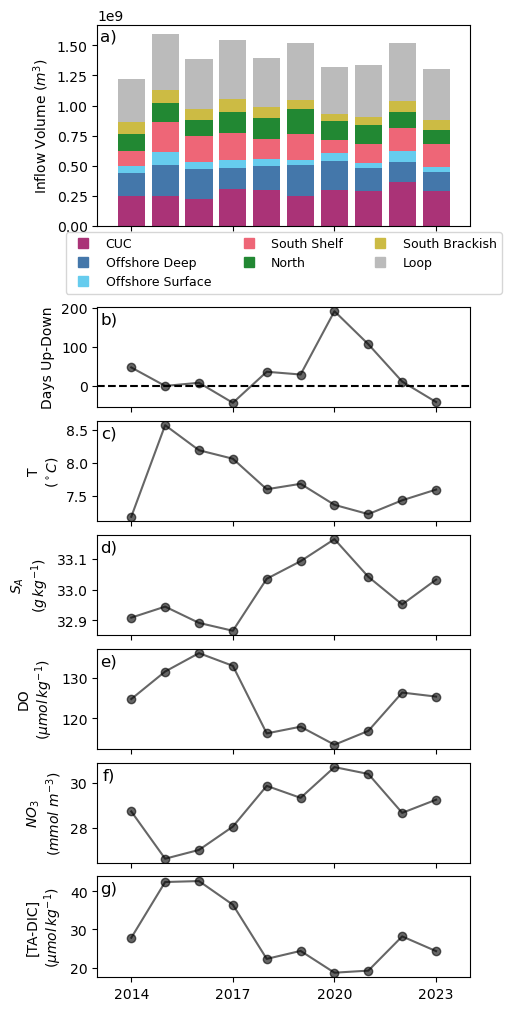

In [12]:
## Interannual variability in watermass inflow with average properties
# with loop flow
# Assign colors to each section
colors = ['#AA3377','#4477AA','#66CCEE','#EE6677','#228833','#CCBB44','#BBBBBB']

# fig, ax = plt.subplots(8,1,figsize=[5,3*8])
fig = plt.figure(constrained_layout=True, figsize=[5,10])
gs = GridSpec(8, 1, figure=fig)
ax1 = fig.add_subplot(gs[:2, 0])
ax3 = fig.add_subplot(gs[2, 0])
ax4 = fig.add_subplot(gs[3,0]) # temp
ax5 = fig.add_subplot(gs[4,0]) # salt
ax6 = fig.add_subplot(gs[5,0]) # DO
ax7 = fig.add_subplot(gs[6,0]) # NO3
ax8 = fig.add_subplot(gs[7,0]) # TA-DIC   

# Plot all 
all_cum_values = np.zeros(len(all.columns[:-1]))
for i in range(len(all)):
    bars = ax1.bar(pd.to_numeric((all.columns[:-1])), all.iloc[i,:-1], bottom=all_cum_values, color=colors[i % len(colors)])
    all_cum_values += all.iloc[i,:-1]
ax1.text(.03, 0.98, 'a)', ha='center', va='top', transform=ax1.transAxes, fontsize=12)
ax1.set_ylabel('Inflow Volume ($m^3$)')


# Customize plot
for axs in [ax1,ax3,ax4,ax5,ax6,ax7,ax8]:
    axs.set_xlim([2013,2024])
    axs.set_xticks([2014,2017,2020,2023])
for axs in [ax1,ax3,ax4,ax5,ax6,ax7]:
    axs.set_xticklabels([])

# # build legend handles    
legend_handles = []
regions = ['CUC', 'Offshore Deep', 'Offshore Surface', 'South Shelf', 'North', 'South Brackish','Loop']
for i in range(len(regions)):
    legend_handles.append(mlines.Line2D([], [], 
                          marker='s', linestyle='None',markersize=7,
                          markeredgecolor=colors[i], markerfacecolor=colors[i],
                          label=regions[i]))
# Add a figure-wide legend below the subplots
ax1.legend(handles=legend_handles, loc='upper center', ncol=3, bbox_to_anchor=(0.5, -0.0001), frameon=True,fontsize=9)

# season ratio
ax3.plot(np.arange(2014,2024,1),lup-ldw, alpha=0.6,c='k',marker='o')
ax3.set_ylabel('Days Up-Down',fontsize=10)
ax3.plot([2013,2024],[0,0],'k--')
ax3.text(.03, 0.95, 'b)', ha='center', va='top', transform=ax3.transAxes, fontsize=12)

# temperature
ax4.plot(np.arange(2014,2024,1),temp, alpha=0.6,c='k',marker='o')
ax4.set_ylabel('T\n($^\circ C$)',fontsize=10)
# ax4.plot([2013,2024],[0,0],'k--')
ax4.text(.03, 0.95, 'c)', ha='center', va='top', transform=ax4.transAxes, fontsize=12)

#salt
ax5.plot(np.arange(2014,2024,1),salt, alpha=0.6,c='k',marker='o')
ax5.set_ylabel('$S_A$\n$(g\,kg^{-1}$)',fontsize=10)
# ax5.plot([2013,2024],[0,0],'k--')
ax5.text(.03, 0.95, 'd)', ha='center', va='top', transform=ax5.transAxes, fontsize=12)

# DO
ax6.plot(np.arange(2014,2024,1),DO, alpha=0.6,c='k',marker='o')
ax6.set_ylabel('DO\n($\mu mol \, kg^{-1}$)',fontsize=10)
# ax6.plot([2013,2024],[0,0],'k--')
ax6.text(.03, 0.95, 'e)', ha='center', va='top', transform=ax6.transAxes, fontsize=12)

# NO3
ax7.plot(np.arange(2014,2024,1),NO3, alpha=0.6,c='k',marker='o')
ax7.set_ylabel('$NO_3$\n($mmol\,\,m^{-3}$)',fontsize=10)
# ax7.plot([2013,2024],[0,0],'k--')
ax7.text(.03, 0.95, 'f)', ha='center', va='top', transform=ax7.transAxes, fontsize=12)

# TA-DIC
ax8.plot(np.arange(2014,2024,1),TADIC, alpha=0.6,c='k',marker='o')
ax8.set_ylabel('[TA-DIC]\n($\mu mol \, kg^{-1}$)',fontsize=10)
# ax8.plot([2013,2024],[0,0],'k--')
ax8.text(.03, 0.95, 'g)', ha='center', va='top', transform=ax8.transAxes, fontsize=12)

plt.savefig('/ocean/rbeutel/MOAD/biogeo_paper/PI_BIOGEO_PAPER/model/figures/volumebar_loop.jpg')


<>:5: SyntaxWarning: invalid escape sequence '\,'
<>:12: SyntaxWarning: invalid escape sequence '\,'
<>:5: SyntaxWarning: invalid escape sequence '\,'
<>:12: SyntaxWarning: invalid escape sequence '\,'
/tmp/ipykernel_3698057/715686454.py:5: SyntaxWarning: invalid escape sequence '\,'
  ax.set_ylabel('Density Anomaly\n($kg \, m^{-3}$)',fontsize=10)
/tmp/ipykernel_3698057/715686454.py:12: SyntaxWarning: invalid escape sequence '\,'
  ax2.set_ylabel('$S_A$\n$(g\,kg^{-1}$)',fontsize=10,color='r')


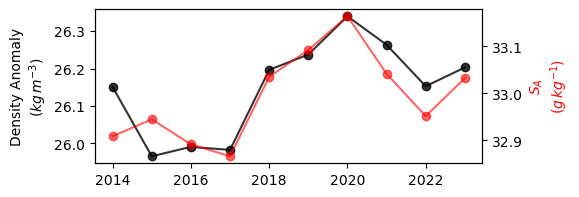

In [13]:
fig, ax = plt.subplots(1,1,figsize=[5,2])

# density
ax.plot(np.arange(2014,2024,1),np.array(density)-1000, alpha=0.8,c='k',marker='o')
ax.set_ylabel('Density Anomaly\n($kg \, m^{-3}$)',fontsize=10)
# ax.plot([2013,2024],[0,0],'k--')
# ax.text(.03, 0.95, 'g)', ha='center', va='top', transform=ax8.transAxes, fontsize=12)

# lets do salinity too to show how related they are
ax2 = ax.twinx()
ax2.plot(np.arange(2014,2024,1),salt, alpha=0.6,c='r',marker='o')
ax2.set_ylabel('$S_A$\n$(g\,kg^{-1}$)',fontsize=10,color='r')

plt.savefig("/ocean/rbeutel/MOAD/biogeo_paper/PI_BIOGEO_PAPER/model/figures/annualdensity.jpg",bbox_inches='tight')

In [14]:
# correlation of salt and density
print(pearsonr(salt,density))

PearsonRResult(statistic=np.float64(0.8745505497364401), pvalue=np.float64(0.0009288153930043951))


In [15]:
# print annual mean inflow volume from each watermass
for i in range(len(all)):
    print(all.section[i+1],'= ',np.mean(all.iloc[i,:-1]),'(',np.std(all.iloc[i,:-1]),') m3')

print('\n')
# print annual mean inflow percentage from each watermass
for i in range(len(all)):
    print(all.section[i+1],'= ',np.round(np.mean(all.iloc[i,:-1]/np.sum(all.iloc[:,:-1],axis=0)),3)*100,' %')

print('\n')
# print annual mean inflow percentage from each watermass without loop included
for i in range(len(all)-1):
    print(all.section[i+1],'= ',np.round(np.mean(all.iloc[i,:-1]/np.sum(all.iloc[:-1,:-1],axis=0)),3)*100,' %')

cuc =  282709831.3183142 ( 40284287.58704831 ) m3
offd =  209543503.12620655 ( 38225483.380166665 ) m3
offs =  61364604.096710086 ( 21568657.902401093 ) m3
north =  183710508.7856233 ( 42799019.6106439 ) m3
south =  155536248.95541143 ( 24657067.397870835 ) m3
fresh =  87841333.8962766 ( 16516629.576826477 ) m3
loop =  433689333.48135424 ( 40336327.269907266 ) m3


cuc =  20.1  %
offd =  14.899999999999999  %
offs =  4.3  %
north =  12.9  %
south =  11.0  %
fresh =  6.2  %
loop =  30.7  %


cuc =  28.999999999999996  %
offd =  21.4  %
offs =  6.2  %
north =  18.6  %
south =  15.9  %
fresh =  9.0  %


In [16]:
alls = [all14,all15,all16,all17,all18,all19,all20,all21,all22,all23]

perc_cuc = [np.round((alls[i].transport[1])/(alls[i].transport[0]-alls[i].transport[7])*100,2) for i in range(len(alls))]
perc_ofd = [np.round((alls[i].transport[2])/(alls[i].transport[0]-alls[i].transport[7])*100,2) for i in range(len(alls))]
perc_ofs = [np.round((alls[i].transport[3])/(alls[i].transport[0]-alls[i].transport[7])*100,2) for i in range(len(alls))]
perc_sou = [np.round((alls[i].transport[5])/(alls[i].transport[0]-alls[i].transport[7])*100,2) for i in range(len(alls))]
perc_nor = [np.round((alls[i].transport[4])/(alls[i].transport[0]-alls[i].transport[7])*100,2) for i in range(len(alls))]
perc_bra = [np.round((alls[i].transport[6])/(alls[i].transport[0]-alls[i].transport[7])*100,2) for i in range(len(alls))]

print(perc_cuc)
print(perc_ofd)
print(perc_ofs)
print(perc_sou)
print(perc_nor)
print(perc_bra)


[np.float64(28.54), np.float64(21.83), np.float64(22.99), np.float64(29.17), np.float64(30.6), np.float64(23.66), np.float64(31.95), np.float64(32.57), np.float64(35.54), np.float64(33.19)]
[np.float64(22.91), np.float64(22.96), np.float64(25.67), np.float64(16.63), np.float64(20.13), np.float64(24.77), np.float64(26.43), np.float64(21.05), np.float64(15.77), np.float64(17.64)]
[np.float64(5.98), np.float64(9.75), np.float64(6.31), np.float64(5.67), np.float64(5.59), np.float64(4.18), np.float64(7.1), np.float64(4.14), np.float64(8.58), np.float64(4.46)]
[np.float64(14.76), np.float64(21.67), np.float64(21.7), np.float64(21.75), np.float64(16.89), np.float64(20.25), np.float64(11.14), np.float64(16.98), np.float64(18.89), np.float64(21.88)]
[np.float64(16.36), np.float64(14.24), np.float64(13.65), np.float64(15.91), np.float64(17.46), np.float64(19.94), np.float64(16.71), np.float64(18.21), np.float64(13.06), np.float64(13.16)]
[np.float64(11.45), np.float64(9.55), np.float64(9.68), np

In [17]:
# to fix 101 summing error: 
# 2015 - south should be round down to 21
# 2016 - north should be round down to 13
# 2017 - off deep should be round down to 16
# 2022 - CUC should be round down to 35

perc_cuc = [int(np.round((alls[i].transport[1])/(alls[i].transport[0]-alls[i].transport[7])*100,0)) for i in range(len(alls))]
perc_ofd = [int(np.round((alls[i].transport[2])/(alls[i].transport[0]-alls[i].transport[7])*100,0)) for i in range(len(alls))]
perc_ofs = [int(np.round((alls[i].transport[3])/(alls[i].transport[0]-alls[i].transport[7])*100,0)) for i in range(len(alls))]
perc_sou = [int(np.round((alls[i].transport[5])/(alls[i].transport[0]-alls[i].transport[7])*100,0)) for i in range(len(alls))]
perc_nor = [int(np.round((alls[i].transport[4])/(alls[i].transport[0]-alls[i].transport[7])*100,0)) for i in range(len(alls))]
perc_bra = [int(np.round((alls[i].transport[6])/(alls[i].transport[0]-alls[i].transport[7])*100,0)) for i in range(len(alls))]

perc_sou[1] = 21
perc_nor[2] = 13
perc_ofd[3] = 16
perc_cuc[-2] = 35

<>:57: SyntaxWarning: invalid escape sequence '\c'
<>:63: SyntaxWarning: invalid escape sequence '\,'
<>:69: SyntaxWarning: invalid escape sequence '\m'
<>:75: SyntaxWarning: invalid escape sequence '\,'
<>:81: SyntaxWarning: invalid escape sequence '\m'
<>:57: SyntaxWarning: invalid escape sequence '\c'
<>:63: SyntaxWarning: invalid escape sequence '\,'
<>:69: SyntaxWarning: invalid escape sequence '\m'
<>:75: SyntaxWarning: invalid escape sequence '\,'
<>:81: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_3698057/4215079259.py:57: SyntaxWarning: invalid escape sequence '\c'
  ax4.set_ylabel('T\n($^\circ C$)',fontsize=10)
/tmp/ipykernel_3698057/4215079259.py:63: SyntaxWarning: invalid escape sequence '\,'
  ax5.set_ylabel('$S_A$\n$(g\,kg^{-1}$)',fontsize=10)
/tmp/ipykernel_3698057/4215079259.py:69: SyntaxWarning: invalid escape sequence '\m'
  ax6.set_ylabel('DO\n($\mu mol \,\, kg^{-1}$)',fontsize=10)
/tmp/ipykernel_3698057/4215079259.py:75: SyntaxWarning: invalid escape s

Text(0.99, 0.98, '# = percentage contribution')

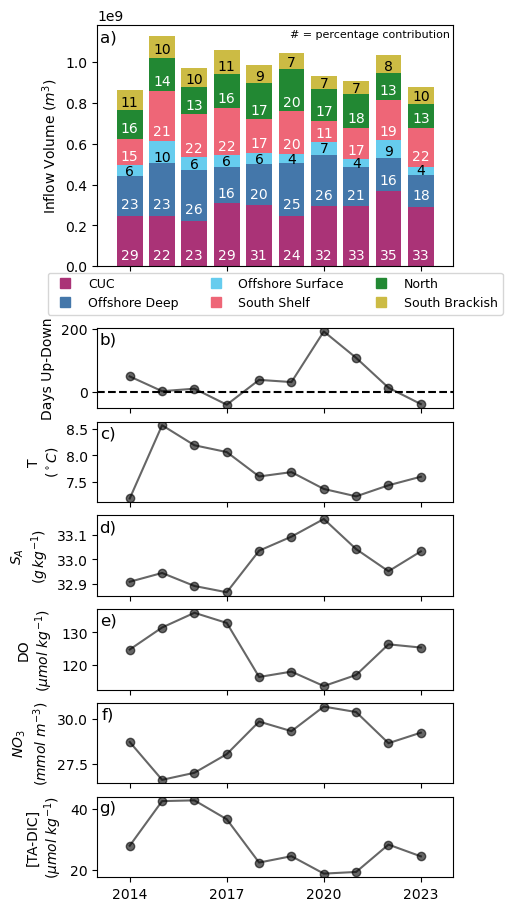

In [18]:
## Interannual varriability in watermass inflow with average properties
# without loop flow
# Assign colors to each section
colors = ['#AA3377','#4477AA','#66CCEE','#EE6677','#228833','#CCBB44','#BBBBBB']

# fig, ax = plt.subplots(8,1,figsize=[5,3*8])
fig = plt.figure(constrained_layout=True, figsize=[5,9])
gs = GridSpec(9, 1, figure=fig)
ax1 = fig.add_subplot(gs[:3, 0])
ax3 = fig.add_subplot(gs[3, 0])
ax4 = fig.add_subplot(gs[4,0]) # temp
ax5 = fig.add_subplot(gs[5,0]) # salt
ax6 = fig.add_subplot(gs[6,0]) # DO
ax7 = fig.add_subplot(gs[7,0]) # NO3
ax8 = fig.add_subplot(gs[8,0]) # TA-DIC   

# Plot all 
allX = all[all.section!='loop']
all_cum_values = np.zeros(len(allX.columns[:-1]))
for i in range(len(allX)):
    bars = ax1.bar(pd.to_numeric((allX.columns[:-1])), allX.iloc[i,:-1], bottom=all_cum_values, color=colors[i % len(colors)])
    all_cum_values += allX.iloc[i,:-1]
ax1.text(.03, 0.98, 'a)', ha='center', va='top', transform=ax1.transAxes, fontsize=12)
ax1.set_ylabel('Inflow Volume ($m^3$)')


# Customize plot
# axs.set_ylim(0,360000000000)
# axs.set_yticks([0,50000,150000])
# axs.set_yticklabels([0,50,150])
axs.set_ylabel('Inflow Volume [$m^3$]')
for axs in [ax1,ax3,ax4,ax5,ax6,ax7,ax8]:
    axs.set_xlim([2013,2024])
    axs.set_xticks([2014,2017,2020,2023])
for axs in [ax1,ax3,ax4,ax5,ax6,ax7]:
    axs.set_xticklabels([])

# # build legend handles    
legend_handles = []
regions = ['CUC', 'Offshore Deep', 'Offshore Surface', 'South Shelf', 'North', 'South Brackish']
for i in range(len(regions)):
    legend_handles.append(mlines.Line2D([], [], 
                          marker='s', linestyle='None',markersize=7,
                          markeredgecolor=colors[i], markerfacecolor=colors[i],
                          label=regions[i]))
# Add a figure-wide legend below the subplots
ax1.legend(handles=legend_handles, loc='upper center', ncol=3, bbox_to_anchor=(0.5, -0.0001), frameon=True,fontsize=9)

# season ratio
ax3.plot(np.arange(2014,2024,1),lup-ldw, alpha=0.6,c='k',marker='o')
ax3.set_ylabel('Days Up-Down',fontsize=10)
ax3.plot([2013,2024],[0,0],'k--')
ax3.text(.03, 0.95, 'b)', ha='center', va='top', transform=ax3.transAxes, fontsize=12)

# temperature
ax4.plot(np.arange(2014,2024,1),temp, alpha=0.6,c='k',marker='o')
ax4.set_ylabel('T\n($^\circ C$)',fontsize=10)
# ax4.plot([2013,2024],[0,0],'k--')
ax4.text(.03, 0.95, 'c)', ha='center', va='top', transform=ax4.transAxes, fontsize=12)

#salt
ax5.plot(np.arange(2014,2024,1),salt, alpha=0.6,c='k',marker='o')
ax5.set_ylabel('$S_A$\n$(g\,kg^{-1}$)',fontsize=10)
# ax5.plot([2013,2024],[0,0],'k--')
ax5.text(.03, 0.95, 'd)', ha='center', va='top', transform=ax5.transAxes, fontsize=12)

# DO
ax6.plot(np.arange(2014,2024,1),DO, alpha=0.6,c='k',marker='o')
ax6.set_ylabel('DO\n($\mu mol \,\, kg^{-1}$)',fontsize=10)
# ax6.plot([2013,2024],[0,0],'k--')
ax6.text(.03, 0.95, 'e)', ha='center', va='top', transform=ax6.transAxes, fontsize=12)

# NO3
ax7.plot(np.arange(2014,2024,1),NO3, alpha=0.6,c='k',marker='o')
ax7.set_ylabel('$NO_3$\n($mmol\,\,m^{-3}$)',fontsize=10)
# ax7.plot([2013,2024],[0,0],'k--')
ax7.text(.03, 0.95, 'f)', ha='center', va='top', transform=ax7.transAxes, fontsize=12)

# TA-DIC
ax8.plot(np.arange(2014,2024,1),TADIC, alpha=0.6,c='k',marker='o')
ax8.set_ylabel('[TA-DIC]\n($\mu mol \,\, kg^{-1}$)',fontsize=10)
# ax8.plot([2013,2024],[0,0],'k--')
ax8.text(.03, 0.95, 'g)', ha='center', va='top', transform=ax8.transAxes, fontsize=12)


# Add percentage text
w = np.linspace(0.065,0.885,10)+0.025
Hcuc = [0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.03]
Hoffd = [0.24,0.24,0.22,0.285,0.28,0.24,0.275,0.275,0.34,0.275]
Hoffs = [0.375,0.435,0.405,0.418,0.425,0.425,0.47,0.41,0.46,0.38]
Hsou = [0.44,0.54,0.47,0.48,0.49,0.486,0.535,0.465,0.54,0.44]
Hnor = [0.555,0.75,0.65,0.68,0.63,0.66,0.625,0.595,0.71,0.595]
Hbra = [0.66,0.88,0.755,0.81,0.77,0.825,0.74,0.72,0.81,0.685]

for i in range(len(alls)):
    ax1.text(w[i],Hcuc[i],perc_cuc[i],ha='center', color='w',transform=ax1.transAxes)
    ax1.text(w[i],Hoffd[i],perc_ofd[i],ha='center', color='w',transform=ax1.transAxes)
    ax1.text(w[i],Hoffs[i],perc_ofs[i],ha='center', color='k',transform=ax1.transAxes)
    ax1.text(w[i],Hsou[i],perc_sou[i],ha='center', color='w',transform=ax1.transAxes)
    ax1.text(w[i],Hnor[i],perc_nor[i],ha='center', color='w',transform=ax1.transAxes)
    ax1.text(w[i],Hbra[i],perc_bra[i],ha='center', color='k',transform=ax1.transAxes)
ax1.text(0.99,0.98,'# = percentage contribution',ha='right', va='top', color='k',fontsize=8, transform=ax1.transAxes)


# plt.savefig('/ocean/rbeutel/MOAD/biogeo_paper/PI_BIOGEO_PAPER/model/figures/volumebar.jpg')


In [19]:
# percentage of mean the standard devation is
for i in range(len(all)):
    print(all.section[i+1],'= ',100*(np.std(all.iloc[i,:-1])/np.mean(all.iloc[i,:-1])),'%')

cuc =  14.249340887509012 %
offd =  18.242266073572193 %
offs =  35.14836968296752 %
north =  23.29699040820099 %
south =  15.852939468110378 %
fresh =  18.80279914274683 %
loop =  9.300742295438875 %


In [20]:
# print upwelling mean inflow volume from each watermass
for i in range(len(all)):
    print(all.section[i+1],'= ',np.mean(up.iloc[i,1:]),' m3')

print('\n')
# print upwelling mean inflow percentage from each watermass
for i in range(len(all)):
    print(all.section[i+1],'= ',np.round(np.mean(up.iloc[i,1:]/np.sum(up.iloc[:,1:],axis=0)),3)*100,' %')

cuc =  6816948.323546503  m3
offd =  6639955.36976949  m3
offs =  1298385.1022724344  m3
north =  5600811.118353333  m3
south =  855900.7662751805  m3
fresh =  114102.35569492646  m3
loop =  7358581.427632126  m3


cuc =  24.099999999999998  %
offd =  22.900000000000002  %
offs =  4.6  %
north =  19.6  %
south =  3.0  %
fresh =  0.3  %
loop =  25.4  %


In [21]:
# print downwelling mean inflow volume from each watermass
for i in range(len(all)):
    print(all.section[i+1],'= ',np.mean(dw.iloc[i,:]),' m3')

print('\n')
# print downwelling mean inflow percentage from each watermass
for i in range(len(all)):
    print(all.section[i+1],'= ',np.round(np.mean(dw.iloc[i,:]/np.sum(dw.iloc[:,:],axis=0)),3)*100,' %')

cuc =  2671836.033586351  m3
offd =  622709.5387346759  m3
offs =  571195.5454219184  m3
north =  197999.62853191356  m3
south =  4797785.235486201  m3
fresh =  2985310.3147340138  m3
loop =  7242081.069504087  m3


cuc =  14.000000000000002  %
offd =  3.0  %
offs =  2.7  %
north =  1.3  %
south =  24.3  %
fresh =  16.6  %
loop =  38.0  %


In [22]:
# correlation with length of upweling and downwelling to volume from each watermass

# first with length of upwelling
print(pearsonr(lup,all[["2014","2015","2016","2017","2018","2019","2020","2021","2022","2023"]][all.section=='cuc'].values[0]))
print(pearsonr(lup,all[["2014","2015","2016","2017","2018","2019","2020","2021","2022","2023"]][all.section=='offd'].values[0]))
print(pearsonr(lup,all[["2014","2015","2016","2017","2018","2019","2020","2021","2022","2023"]][all.section=='offs'].values[0]))
print(pearsonr(lup,all[["2014","2015","2016","2017","2018","2019","2020","2021","2022","2023"]][all.section=='north'].values[0]))
print(pearsonr(lup,all[["2014","2015","2016","2017","2018","2019","2020","2021","2022","2023"]][all.section=='south'].values[0]))
print(pearsonr(lup,all[["2014","2015","2016","2017","2018","2019","2020","2021","2022","2023"]][all.section=='fresh'].values[0]))
print(pearsonr(lup,all[["2014","2015","2016","2017","2018","2019","2020","2021","2022","2023"]][all.section=='loop'].values[0]))

# significant negative correlation with freshwater inflow (alpha=0.1)

PearsonRResult(statistic=np.float64(-0.2458083204647851), pvalue=np.float64(0.49362252337753204))
PearsonRResult(statistic=np.float64(0.5174315803612028), pvalue=np.float64(0.1255850067497664))
PearsonRResult(statistic=np.float64(-0.27549958275395703), pvalue=np.float64(0.4410407881733459))
PearsonRResult(statistic=np.float64(0.36566663835433727), pvalue=np.float64(0.29875237835310453))
PearsonRResult(statistic=np.float64(-0.5336765295238198), pvalue=np.float64(0.11210996014008731))
PearsonRResult(statistic=np.float64(-0.6177056540388675), pvalue=np.float64(0.05703409718641946))
PearsonRResult(statistic=np.float64(-0.2900703152113016), pvalue=np.float64(0.4162195836205868))


In [23]:
# length of downwelling
print(pearsonr(ldw,all[["2014","2015","2016","2017","2018","2019","2020","2021","2022","2023"]][all.section=='cuc'].values[0]))
print(pearsonr(ldw,all[["2014","2015","2016","2017","2018","2019","2020","2021","2022","2023"]][all.section=='offd'].values[0]))
print(pearsonr(ldw,all[["2014","2015","2016","2017","2018","2019","2020","2021","2022","2023"]][all.section=='offs'].values[0]))
print(pearsonr(ldw,all[["2014","2015","2016","2017","2018","2019","2020","2021","2022","2023"]][all.section=='north'].values[0]))
print(pearsonr(ldw,all[["2014","2015","2016","2017","2018","2019","2020","2021","2022","2023"]][all.section=='south'].values[0]))
print(pearsonr(ldw,all[["2014","2015","2016","2017","2018","2019","2020","2021","2022","2023"]][all.section=='fresh'].values[0]))
print(pearsonr(ldw,all[["2014","2015","2016","2017","2018","2019","2020","2021","2022","2023"]][all.section=='loop'].values[0]))

# significant positive correlation with south inflow (alpha=0.01)
# significant positive correlation with fresh inflow (alpha=0.1)

PearsonRResult(statistic=np.float64(-0.2628890374051897), pvalue=np.float64(0.4630527748814674))
PearsonRResult(statistic=np.float64(-0.11511732917291304), pvalue=np.float64(0.7514914994925778))
PearsonRResult(statistic=np.float64(-0.06074770323977165), pvalue=np.float64(0.8676036998534195))
PearsonRResult(statistic=np.float64(0.002688872716589241), pvalue=np.float64(0.9941181334586937))
PearsonRResult(statistic=np.float64(0.7883349157398548), pvalue=np.float64(0.006741879266925218))
PearsonRResult(statistic=np.float64(0.6318655248891941), pvalue=np.float64(0.050014861899901564))
PearsonRResult(statistic=np.float64(0.5398917567715724), pvalue=np.float64(0.10720542797644435))


In [24]:
# difference
print(pearsonr(lup-ldw,all[["2014","2015","2016","2017","2018","2019","2020","2021","2022","2023"]][all.section=='cuc'].values[0]))
print(pearsonr(lup-ldw,all[["2014","2015","2016","2017","2018","2019","2020","2021","2022","2023"]][all.section=='offd'].values[0]))
print(pearsonr(lup-ldw,all[["2014","2015","2016","2017","2018","2019","2020","2021","2022","2023"]][all.section=='offs'].values[0]))
print(pearsonr(lup-ldw,all[["2014","2015","2016","2017","2018","2019","2020","2021","2022","2023"]][all.section=='north'].values[0]))
print(pearsonr(lup-ldw,all[["2014","2015","2016","2017","2018","2019","2020","2021","2022","2023"]][all.section=='south'].values[0]))
print(pearsonr(lup-ldw,all[["2014","2015","2016","2017","2018","2019","2020","2021","2022","2023"]][all.section=='fresh'].values[0]))
print(pearsonr(lup-ldw,all[["2014","2015","2016","2017","2018","2019","2020","2021","2022","2023"]][all.section=='loop'].values[0]))

# significant negaitve correlation with south inflow (alpha=0.01)
# significant negative correlation with fresh inflow (alpha=0.1)

PearsonRResult(statistic=np.float64(0.04094383012271603), pvalue=np.float64(0.9105853665388489))
PearsonRResult(statistic=np.float64(0.3544206663736996), pvalue=np.float64(0.31497228230541385))
PearsonRResult(statistic=np.float64(-0.10827027280167932), pvalue=np.float64(0.7659156651487501))
PearsonRResult(statistic=np.float64(0.19507595106135578), pvalue=np.float64(0.5891429343356044))
PearsonRResult(statistic=np.float64(-0.8068806240042069), pvalue=np.float64(0.004785412150818858))
PearsonRResult(statistic=np.float64(-0.7489874453387586), pvalue=np.float64(0.012664323985038237))
PearsonRResult(statistic=np.float64(-0.5119930182351852), pvalue=np.float64(0.13031023067550032))


In [25]:
# what about comparison to the strength of upwelling and downwelling?
# basing this on the Bakun index at 45

bak48 = pd.read_csv('/ocean/rbeutel/MOAD/biogeo_paper/PI_BIOGEO_PAPER/model/Bakun.txt', sep="\s+", header=5)
bak48['date'] = pd.to_datetime(bak48.YYYYMMDD, format='%Y%m%d', errors='coerce')
bak48 = bak48.sort_values(by='date')
# drop values greater than -500
bak48.loc[bak48.Index<=-500, "Index"] = 0

# come up with a function to identify the strength of upwelling (take annual peak) and downwelling (take annual trough)
bak48['year'] = [bak48.date[i].year for i in range(len(bak48))]
bak48 = bak48[(bak48.year >= 2014) & (bak48.year <= 2023)] #drop years we're not working with

peak = np.empty(len(set(bak48.year)),dtype='float')
trough = np.empty(len(set(bak48.year)),dtype='float')
i=0
for year in set(bak48.year):
    data = bak48.Index[bak48.year == year]

    peak[i] = np.max(data)
    trough[i] = np.min(data)
    i+=1

<>:4: SyntaxWarning: invalid escape sequence '\s'
<>:4: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_3698057/2402821787.py:4: SyntaxWarning: invalid escape sequence '\s'
  bak48 = pd.read_csv('/ocean/rbeutel/MOAD/biogeo_paper/PI_BIOGEO_PAPER/model/Bakun.txt', sep="\s+", header=5)


In [26]:
# first with strength of upwelling
print(pearsonr(peak,all[["2014","2015","2016","2017","2018","2019","2020","2021","2022","2023"]][all.section=='cuc'].values[0]))
print(pearsonr(peak,all[["2014","2015","2016","2017","2018","2019","2020","2021","2022","2023"]][all.section=='offd'].values[0]))
print(pearsonr(peak,all[["2014","2015","2016","2017","2018","2019","2020","2021","2022","2023"]][all.section=='offs'].values[0]))
print(pearsonr(peak,all[["2014","2015","2016","2017","2018","2019","2020","2021","2022","2023"]][all.section=='north'].values[0]))
print(pearsonr(peak,all[["2014","2015","2016","2017","2018","2019","2020","2021","2022","2023"]][all.section=='south'].values[0]))
print(pearsonr(peak,all[["2014","2015","2016","2017","2018","2019","2020","2021","2022","2023"]][all.section=='fresh'].values[0]))
print(pearsonr(peak,all[["2014","2015","2016","2017","2018","2019","2020","2021","2022","2023"]][all.section=='loop'].values[0]))

# north water correlated to the strength of upwelling! 
# NOTE i orriginally tried this with the Bakun index at 45 and it was not correlated, correlation only appeared with the bakun index at 48

PearsonRResult(statistic=np.float64(-0.3936143398491037), pvalue=np.float64(0.26042669144375147))
PearsonRResult(statistic=np.float64(0.32708683890430174), pvalue=np.float64(0.3562575424634095))
PearsonRResult(statistic=np.float64(-0.38924290979600285), pvalue=np.float64(0.2662328418523788))
PearsonRResult(statistic=np.float64(0.7254978767959106), pvalue=np.float64(0.017557181621224355))
PearsonRResult(statistic=np.float64(0.08587035445185114), pvalue=np.float64(0.8135375719122797))
PearsonRResult(statistic=np.float64(-0.21446696029305948), pvalue=np.float64(0.5518434169057869))
PearsonRResult(statistic=np.float64(0.16019817231192734), pvalue=np.float64(0.6584221984164291))


In [27]:
# first with strength of downwelling
print(pearsonr(trough,all[["2014","2015","2016","2017","2018","2019","2020","2021","2022","2023"]][all.section=='cuc'].values[0]))
print(pearsonr(trough,all[["2014","2015","2016","2017","2018","2019","2020","2021","2022","2023"]][all.section=='offd'].values[0]))
print(pearsonr(trough,all[["2014","2015","2016","2017","2018","2019","2020","2021","2022","2023"]][all.section=='offs'].values[0]))
print(pearsonr(trough,all[["2014","2015","2016","2017","2018","2019","2020","2021","2022","2023"]][all.section=='north'].values[0]))
print(pearsonr(trough,all[["2014","2015","2016","2017","2018","2019","2020","2021","2022","2023"]][all.section=='south'].values[0]))
print(pearsonr(trough,all[["2014","2015","2016","2017","2018","2019","2020","2021","2022","2023"]][all.section=='fresh'].values[0]))
print(pearsonr(trough,all[["2014","2015","2016","2017","2018","2019","2020","2021","2022","2023"]][all.section=='loop'].values[0]))

# not a single significant correlation

PearsonRResult(statistic=np.float64(0.32294032920587074), pvalue=np.float64(0.36274651201692365))
PearsonRResult(statistic=np.float64(-0.21816153361239582), pvalue=np.float64(0.5448437989273797))
PearsonRResult(statistic=np.float64(-0.08127103181576559), pvalue=np.float64(0.823389207714646))
PearsonRResult(statistic=np.float64(-0.271716716203073), pvalue=np.float64(0.447593005956941))
PearsonRResult(statistic=np.float64(0.003263890032456503), pvalue=np.float64(0.9928603166132167))
PearsonRResult(statistic=np.float64(-0.19778288174610562), pvalue=np.float64(0.5838808495707503))
PearsonRResult(statistic=np.float64(-0.008696565514904964), pvalue=np.float64(0.9809777016408814))


In [28]:
# corellation of length of downwelling to the tracers
measure = ldw
print(pearsonr(measure,salt))
print(pearsonr(measure,temp))
print(pearsonr(measure,DO))
print(pearsonr(measure,NO3))
print(pearsonr(measure,TADIC))

PearsonRResult(statistic=np.float64(-0.5259360893045054), pvalue=np.float64(0.11841167183087918))
PearsonRResult(statistic=np.float64(0.5786822759991439), pvalue=np.float64(0.07965588562166787))
PearsonRResult(statistic=np.float64(0.6773656948921704), pvalue=np.float64(0.031404885633621905))
PearsonRResult(statistic=np.float64(-0.6000359994630771), pvalue=np.float64(0.06666735855796728))
PearsonRResult(statistic=np.float64(0.5795588826510683), pvalue=np.float64(0.07909293292413812))


In [29]:
# corellation of length of upwelling to the tracers
measure = lup
print(pearsonr(measure,salt))
print(pearsonr(measure,temp))
print(pearsonr(measure,DO))
print(pearsonr(measure,NO3))
print(pearsonr(measure,TADIC))

PearsonRResult(statistic=np.float64(0.6182714273163482), pvalue=np.float64(0.05674185287109749))
PearsonRResult(statistic=np.float64(-0.27668139669497027), pvalue=np.float64(0.4390028344268154))
PearsonRResult(statistic=np.float64(-0.5168819344419009), pvalue=np.float64(0.126057658130722))
PearsonRResult(statistic=np.float64(0.494639659091988), pvalue=np.float64(0.14611317488099684))
PearsonRResult(statistic=np.float64(-0.4010757890380696), pvalue=np.float64(0.2506793405274619))


In [30]:
# corellation of length of upweling-downwelling to the tracers
measure = lup-ldw
print(pearsonr(measure,salt))
print(pearsonr(measure,temp))
print(pearsonr(measure,DO))
print(pearsonr(measure,NO3))
print(pearsonr(measure,TADIC))

# overall strongest correlations here
# salt, DO, NO3, TA-DIC correlated to lup-ldw at alpha=0.1

PearsonRResult(statistic=np.float64(0.6794743731537884), pvalue=np.float64(0.03067956595915429))
PearsonRResult(statistic=np.float64(-0.5303520709037259), pvalue=np.float64(0.11479009203822663))
PearsonRResult(statistic=np.float64(-0.7247002979552605), pvalue=np.float64(0.017743258694631562))
PearsonRResult(statistic=np.float64(0.661759008237307), pvalue=np.float64(0.037138693379409685))
PearsonRResult(statistic=np.float64(-0.5978946821133299), pvalue=np.float64(0.06790243242496244))


In [31]:
# correlation to salt
measure = salt
# print(pearsonr(measure,salt))
print(pearsonr(measure,temp))
print(pearsonr(measure,DO))
print(pearsonr(measure,NO3))
print(pearsonr(measure,TADIC))

PearsonRResult(statistic=np.float64(-0.4484175745957346), pvalue=np.float64(0.19366979422367742))
PearsonRResult(statistic=np.float64(-0.8788913384042051), pvalue=np.float64(0.0008111923646917464))
PearsonRResult(statistic=np.float64(0.7875946913655986), pvalue=np.float64(0.006830108617230145))
PearsonRResult(statistic=np.float64(-0.7846378649171768), pvalue=np.float64(0.007190728670297113))


In [32]:
# correlation to temp
measure = temp
print(pearsonr(measure,salt))
# print(pearsonr(measure,temp))
print(pearsonr(measure,DO))
print(pearsonr(measure,NO3))
print(pearsonr(measure,TADIC))

PearsonRResult(statistic=np.float64(-0.4484175745957346), pvalue=np.float64(0.19366979422367742))
PearsonRResult(statistic=np.float64(0.7072196185794338), pvalue=np.float64(0.02217306493418018))
PearsonRResult(statistic=np.float64(-0.8299614520798888), pvalue=np.float64(0.002962677152434954))
PearsonRResult(statistic=np.float64(0.8653344012714664), pvalue=np.float64(0.0012190990260960383))


In [33]:
# corellation upweling strength to the tracers
measure = peak
print(pearsonr(measure,salt))
print(pearsonr(measure,temp))
print(pearsonr(measure,DO))
print(pearsonr(measure,NO3))
print(pearsonr(measure,TADIC))

PearsonRResult(statistic=np.float64(0.3740652195369187), pvalue=np.float64(0.2869360155234492))
PearsonRResult(statistic=np.float64(-0.09338549066161299), pvalue=np.float64(0.7974914386528733))
PearsonRResult(statistic=np.float64(-0.3928878127755102), pvalue=np.float64(0.26138678830894285))
PearsonRResult(statistic=np.float64(0.2253579615955945), pvalue=np.float64(0.5313118963516218))
PearsonRResult(statistic=np.float64(-0.28256493064864346), pvalue=np.float64(0.42892170640139216))


In [34]:
# corellation downwelling strength to the tracers
measure = peak
print(pearsonr(measure,salt))
print(pearsonr(measure,temp))
print(pearsonr(measure,DO))
print(pearsonr(measure,NO3))
print(pearsonr(measure,TADIC))

PearsonRResult(statistic=np.float64(0.3740652195369187), pvalue=np.float64(0.2869360155234492))
PearsonRResult(statistic=np.float64(-0.09338549066161299), pvalue=np.float64(0.7974914386528733))
PearsonRResult(statistic=np.float64(-0.3928878127755102), pvalue=np.float64(0.26138678830894285))
PearsonRResult(statistic=np.float64(0.2253579615955945), pvalue=np.float64(0.5313118963516218))
PearsonRResult(statistic=np.float64(-0.28256493064864346), pvalue=np.float64(0.42892170640139216))


## Attribution 

### full year

In [35]:
files = [all14,all15,all16,all17,all18,all19,all20,all21,all22,all23]

for file in files:
    file['TA-DIC'] = file.TA - file.DIC

In [36]:
lcom = [113+161+19+18,143+144+60+46,149+158+19+19,198+156+19+20,
        91+128+88+48,163+193+19+29,53+244+19+25,82+189+42+21,
        105+117+137+20,176+136+19+20] # length of each "year"

In [37]:
# make 'baseline' dataframe based on the means of all the data
d = {'section':['salish','cuc', 'off_d', 'off_s', 'north', 'south', 'fresh','loop'],
     'transport':np.mean([all14.transport*lcom[0],all15.transport*lcom[1],all16.transport*lcom[2],all17.transport*lcom[3],all18.transport*lcom[4],
                          all19.transport*lcom[5],all20.transport*lcom[6],all21.transport*lcom[7],all22.transport*lcom[8],all23.transport*lcom[9]],axis=0),
     'salt':np.mean([all14.salt,all15.salt,all16.salt,all17.salt,all18.salt,all19.salt,all20.salt,all21.salt,all22.salt,all23.salt],axis=0),
     'temp':np.mean([all14.temp,all15.temp,all16.temp,all17.temp,all18.temp,all19.temp,all20.temp,all21.temp,all22.temp,all23.temp],axis=0),
     'DO':np.mean([all14.DO,all15.DO,all16.DO,all17.DO,all18.DO,all19.DO,all20.DO,all21.DO,all22.DO,all23.DO],axis=0),
     'NO3':np.mean([all14.NO3,all15.NO3,all16.NO3,all17.NO3,all18.NO3,all19.NO3,all20.NO3,all21.NO3,all22.NO3,all23.NO3],axis=0),
     'density':np.mean([all14.density,all15.density,all16.density,all17.density,all18.density,all19.density,all20.density,all21.density,all22.density,all23.density],axis=0),
     '[TA-DIC]':np.mean([all14['[TA-DIC]'],all15['[TA-DIC]'],all16['[TA-DIC]'],all17['[TA-DIC]'],all18['[TA-DIC]'],all19['[TA-DIC]'],all20['[TA-DIC]'],all21['[TA-DIC]'],all22['[TA-DIC]'],all23['[TA-DIC]']],axis=0)}
all_b = pd.DataFrame(d)

all_b

,section,transport,salt,temp,DO,NO3,density,[TA-DIC]
0,salish,5.131816e+11,32.992956,7.690263,124.157593,28.861600,1026.148133,28.649991
1,cuc,1.021044e+11,33.844661,6.519460,66.533519,36.526207,1027.641382,-0.773091
2,off_d,7.577457e+10,33.734220,6.686667,89.369098,33.650884,1027.404628,15.377870
3,off_s,2.238251e+10,32.835558,8.832818,215.770443,15.595599,1025.670669,110.734024
4,north,5.644600e+10,33.218864,7.637437,154.908330,23.989951,1026.360387,61.188245
5,south,6.721013e+10,32.864380,9.404059,200.422824,17.840091,1025.623133,96.926976
6,fresh,3.181646e+10,30.039493,10.071364,292.972139,7.480471,1022.992202,168.269883
7,loop,1.574475e+11,32.012657,8.525796,173.457623,27.562427,1025.014179,43.218718


In [38]:
all14.transport = all14.transport*lcom[0]
all15.transport = all15.transport*lcom[1]
all16.transport = all16.transport*lcom[2]
all17.transport = all17.transport*lcom[3]
all18.transport = all18.transport*lcom[4]
all19.transport = all19.transport*lcom[5]
all20.transport = all20.transport*lcom[6]
all21.transport = all21.transport*lcom[7]
all22.transport = all22.transport*lcom[8]
all23.transport = all23.transport*lcom[9]

In [39]:
# math! 
math_all14 = decomp(all14,all_b)[1:]
math_all15 = decomp(all15,all_b)[1:]
math_all16 = decomp(all16,all_b)[1:]
math_all17 = decomp(all17,all_b)[1:]
math_all18 = decomp(all18,all_b)[1:]
math_all19 = decomp(all19,all_b)[1:]
math_all20 = decomp(all20,all_b)[1:]
math_all21 = decomp(all21,all_b)[1:]
math_all22 = decomp(all22,all_b)[1:]
math_all23 = decomp(all23,all_b)[1:]


# add year 
math_all14['year'] = 2014
math_all15['year'] = 2015
math_all16['year'] = 2016
math_all17['year'] = 2017
math_all18['year'] = 2018
math_all19['year'] = 2019
math_all20['year'] = 2020
math_all21['year'] = 2021
math_all22['year'] = 2022
math_all23['year'] = 2023


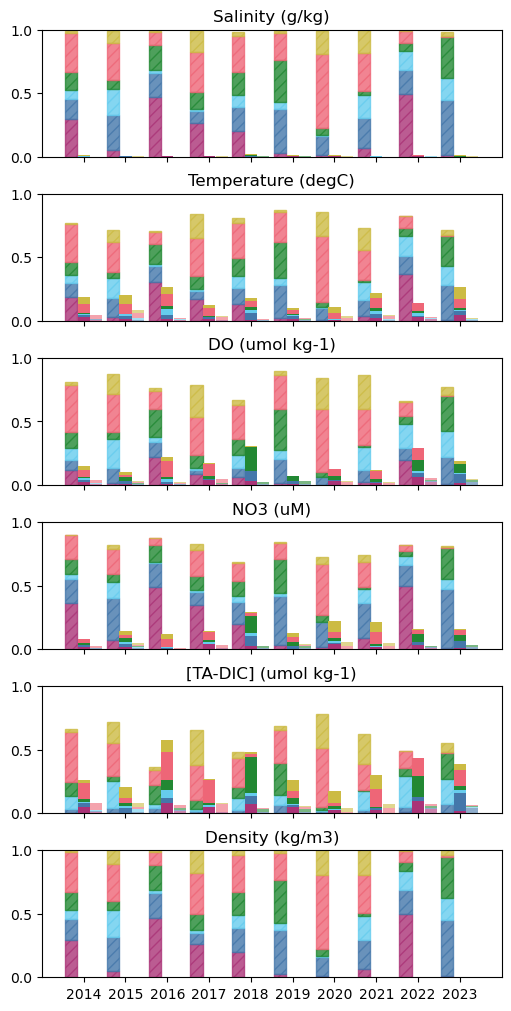

In [40]:
# With cross term
fig = plt.figure(constrained_layout=True, figsize=[5,10])
gs = GridSpec(6, 1, figure=fig)
ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1])
ax3 = fig.add_subplot(gs[2])
ax4 = fig.add_subplot(gs[3])
ax5 = fig.add_subplot(gs[4])
ax6 = fig.add_subplot(gs[5])

# SALINITY
df = pd.concat([math_all14[['year','section','saltP','saltQ','saltX']][:-1],math_all15[['year','section','saltP','saltQ','saltX']][:-1],
    math_all16[['year','section','saltP','saltQ','saltX']][:-1],math_all17[['year','section','saltP','saltQ','saltX']][:-1],
    math_all18[['year','section','saltP','saltQ','saltX']][:-1],math_all19[['year','section','saltP','saltQ','saltX']][:-1],
    math_all20[['year','section','saltP','saltQ','saltX']][:-1],math_all21[['year','section','saltP','saltQ','saltX']][:-1],
    math_all22[['year','section','saltP','saltQ','saltX']][:-1],math_all23[['year','section','saltP','saltQ','saltX']][:-1]])
three_bar(df,'Salinity (g/kg)',ax1)

# TEMPERATURE
df = pd.concat([math_all14[['year','section','tempP','tempQ','tempX']][:-1],math_all15[['year','section','tempP','tempQ','tempX']][:-1],
    math_all16[['year','section','tempP','tempQ','tempX']][:-1],math_all17[['year','section','tempP','tempQ','tempX']][:-1],
    math_all18[['year','section','tempP','tempQ','tempX']][:-1],math_all19[['year','section','tempP','tempQ','tempX']][:-1],
    math_all20[['year','section','tempP','tempQ','tempX']][:-1],math_all21[['year','section','tempP','tempQ','tempX']][:-1],
    math_all22[['year','section','tempP','tempQ','tempX']][:-1],math_all23[['year','section','tempP','tempQ','tempX']][:-1]])
three_bar(df,'Temperature (degC)',ax2)

# DO
df = pd.concat([math_all14[['year','section','DOP','DOQ','DOX']][:-1],math_all15[['year','section','DOP','DOQ','DOX']][:-1],
    math_all16[['year','section','DOP','DOQ','DOX']][:-1],math_all17[['year','section','DOP','DOQ','DOX']][:-1],
    math_all18[['year','section','DOP','DOQ','DOX']][:-1],math_all19[['year','section','DOP','DOQ','DOX']][:-1],
    math_all20[['year','section','DOP','DOQ','DOX']][:-1],math_all21[['year','section','DOP','DOQ','DOX']][:-1],
    math_all22[['year','section','DOP','DOQ','DOX']][:-1],math_all23[['year','section','DOP','DOQ','DOX']][:-1]])
three_bar(df,'DO (umol kg-1)',ax3)

# NO3
df = pd.concat([math_all14[['year','section','NO3P','NO3Q','NO3X']][:-1],math_all15[['year','section','NO3P','NO3Q','NO3X']][:-1],
    math_all16[['year','section','NO3P','NO3Q','NO3X']][:-1],math_all17[['year','section','NO3P','NO3Q','NO3X']][:-1],
    math_all18[['year','section','NO3P','NO3Q','NO3X']][:-1],math_all19[['year','section','NO3P','NO3Q','NO3X']][:-1],
    math_all20[['year','section','NO3P','NO3Q','NO3X']][:-1],math_all21[['year','section','NO3P','NO3Q','NO3X']][:-1],
    math_all22[['year','section','NO3P','NO3Q','NO3X']][:-1],math_all23[['year','section','NO3P','NO3Q','NO3X']][:-1],])
three_bar(df,'NO3 (uM)',ax4)

# TA-DIC
df = pd.concat([math_all14[['year','section','TADICP','TADICQ','TADICX']][:-1],math_all15[['year','section','TADICP','TADICQ','TADICX']][:-1],
    math_all16[['year','section','TADICP','TADICQ','TADICX']][:-1],math_all17[['year','section','TADICP','TADICQ','TADICX']][:-1],
    math_all18[['year','section','TADICP','TADICQ','TADICX']][:-1],math_all19[['year','section','TADICP','TADICQ','TADICX']][:-1],
    math_all20[['year','section','TADICP','TADICQ','TADICX']][:-1],math_all21[['year','section','TADICP','TADICQ','TADICX']][:-1],
    math_all22[['year','section','TADICP','TADICQ','TADICX']][:-1],math_all23[['year','section','TADICP','TADICQ','TADICX']][:-1]])
three_bar(df,'[TA-DIC] (umol kg-1)',ax5)

# dens
df = pd.concat([math_all14[['year','section','densP','densQ','densX']][:-1],math_all15[['year','section','densP','densQ','densX']][:-1],
    math_all16[['year','section','densP','densQ','densX']][:-1],math_all17[['year','section','densP','densQ','densX']][:-1],
    math_all18[['year','section','densP','densQ','densX']][:-1],math_all19[['year','section','densP','densQ','densX']][:-1],
    math_all20[['year','section','densP','densQ','densX']][:-1],math_all21[['year','section','densP','densQ','densX']][:-1],
    math_all22[['year','section','densP','densQ','densX']][:-1],math_all23[['year','section','densP','densQ','densX']][:-1],])
three_bar(df,'Density (kg/m3)',ax6)

ax6.set_xticklabels(np.arange(2014,2024,1));

contribution of each watermass to the variability in each tracer:

In [41]:
# SALT

df = pd.concat([math_all14[['year','section','saltP','saltQ','saltX']][:-1],math_all15[['year','section','saltP','saltQ','saltX']][:-1],
    math_all16[['year','section','saltP','saltQ','saltX']][:-1],math_all17[['year','section','saltP','saltQ','saltX']][:-1],
    math_all18[['year','section','saltP','saltQ','saltX']][:-1],math_all19[['year','section','saltP','saltQ','saltX']][:-1],
    math_all20[['year','section','saltP','saltQ','saltX']][:-1],math_all21[['year','section','saltP','saltQ','saltX']][:-1],
    math_all22[['year','section','saltP','saltQ','saltX']][:-1],math_all23[['year','section','saltP','saltQ','saltX']][:-1]])

df['absP'] = df[df.columns[2]].abs()
df['absQ'] = df[df.columns[3]].abs()
df['absX'] = df[df.columns[4]].abs()
df['total_abs'] = df.groupby('year')[['absP', 'absQ','absX']].transform('sum').sum(axis=1)
df['normP'] = df['absP'] / df['total_abs']
df['normQ'] = df['absQ'] / df['total_abs']
df['normX'] = df['absX'] / df['total_abs']

regions = list(set(df.section))

for region in regions:
    b = df.section == region
    print("{}: P mean = {} ({}), Q mean = {} ({}), X mean = {} ({}), mean total = {} ({}), std% = {}".format(
        region,np.round(np.mean(df.normP[b]),3),np.round(np.std(df.normP[b]),3),
        np.round(np.mean(df.normQ[b]),3),np.round(np.std(df.normQ[b]),3),
        np.round(np.mean(df.normX[b]),3),np.round(np.std(df.normX[b]),3),
        np.round(np.mean(np.sum([df.normP[b],df.normQ[b],df.normX[b]],axis=0)),3),
        np.round(np.std(np.sum([df.normP[b],df.normQ[b],df.normX[b]],axis=0)),3),
        np.round(np.std(np.sum([df.normP[b],df.normQ[b],df.normX[b]],axis=0))/np.mean(np.sum([df.normP[b],df.normQ[b],df.normX[b]],axis=0)),3)*100))

years = list(set(df.year))
Psum = [np.sum(df.normP[df.year == y]) for y in years]
Qsum = [np.sum(df.normQ[df.year == y]) for y in years]
Xsum = [np.sum(df.normX[df.year == y]) for y in years]
print("total P mean = {} ({}), Q mean = {}, ({})".format(np.round(np.mean(Psum),4),np.round(np.std(Psum),4),np.round(np.mean(Qsum),4),np.round(np.std(Qsum),4)))

# 101 - lower north to 15

north: P mean = 0.003 (0.001), Q mean = 0.152 (0.1), X mean = 0.0 (0.0), mean total = 0.155 (0.101), std% = 65.0
south: P mean = 0.001 (0.001), Q mean = 0.249 (0.152), X mean = 0.0 (0.0), mean total = 0.25 (0.151), std% = 60.6
fresh: P mean = 0.004 (0.003), Q mean = 0.073 (0.072), X mean = 0.001 (0.001), mean total = 0.077 (0.072), std% = 92.60000000000001
cuc: P mean = 0.001 (0.001), Q mean = 0.19 (0.177), X mean = 0.0 (0.0), mean total = 0.191 (0.177), std% = 92.9
off_s: P mean = 0.001 (0.001), Q mean = 0.098 (0.072), X mean = 0.0 (0.0), mean total = 0.099 (0.072), std% = 73.0
off_d: P mean = 0.001 (0.002), Q mean = 0.226 (0.096), X mean = 0.0 (0.0), mean total = 0.227 (0.096), std% = 42.3
total P mean = 0.0102 (0.004), Q mean = 0.9882, (0.004)


In [42]:
# TEMP

df = pd.concat([math_all14[['year','section','tempP','tempQ','tempX']][:-1],math_all15[['year','section','tempP','tempQ','tempX']][:-1],
    math_all16[['year','section','tempP','tempQ','tempX']][:-1],math_all17[['year','section','tempP','tempQ','tempX']][:-1],
    math_all18[['year','section','tempP','tempQ','tempX']][:-1],math_all19[['year','section','tempP','tempQ','tempX']][:-1],
    math_all20[['year','section','tempP','tempQ','tempX']][:-1],math_all21[['year','section','tempP','tempQ','tempX']][:-1],
    math_all22[['year','section','tempP','tempQ','tempX']][:-1],math_all23[['year','section','tempP','tempQ','tempX']][:-1]])

df['absP'] = df[df.columns[2]].abs()
df['absQ'] = df[df.columns[3]].abs()
df['absX'] = df[df.columns[4]].abs()
df['total_abs'] = df.groupby('year')[['absP', 'absQ','absX']].transform('sum').sum(axis=1)
df['normP'] = df['absP'] / df['total_abs']
df['normQ'] = df['absQ'] / df['total_abs']
df['normX'] = df['absX'] / df['total_abs']

for region in regions:
    b = df.section == region
    print("{}: P mean = {} ({}), Q mean = {} ({}), X mean = {} ({}), mean total = {} ({}), std% = {}".format(
        region,np.round(np.mean(df.normP[b]),3),np.round(np.std(df.normP[b]),3),
        np.round(np.mean(df.normQ[b]),3),np.round(np.std(df.normQ[b]),3),
        np.round(np.mean(df.normX[b]),3),np.round(np.std(df.normX[b]),3),
        np.round(np.mean(np.sum([df.normP[b],df.normQ[b],df.normX[b]],axis=0)),3),
        np.round(np.std(np.sum([df.normP[b],df.normQ[b],df.normX[b]],axis=0)),3),
        np.round(np.std(np.sum([df.normP[b],df.normQ[b],df.normX[b]],axis=0))/np.mean(np.sum([df.normP[b],df.normQ[b],df.normX[b]],axis=0)),3)*100))

years = list(set(df.year))
Psum = [np.sum(df.normP[df.year == y]) for y in years]
Qsum = [np.sum(df.normQ[df.year == y]) for y in years]
Xsum = [np.sum(df.normX[df.year == y]) for y in years]
print("total P mean = {} ({}), Q mean = {}, ({})".format(np.round(np.mean(Psum),4),np.round(np.std(Psum),4),np.round(np.mean(Qsum),4),np.round(np.std(Qsum),4)))

# 99 - increase offshore surface to 11

north: P mean = 0.013 (0.008), Q mean = 0.119 (0.083), X mean = 0.002 (0.002), mean total = 0.134 (0.086), std% = 64.2
south: P mean = 0.064 (0.019), Q mean = 0.23 (0.134), X mean = 0.015 (0.011), mean total = 0.31 (0.135), std% = 43.6
fresh: P mean = 0.042 (0.026), Q mean = 0.075 (0.073), X mean = 0.007 (0.008), mean total = 0.124 (0.084), std% = 67.5
cuc: P mean = 0.02 (0.012), Q mean = 0.127 (0.124), X mean = 0.003 (0.003), mean total = 0.15 (0.128), std% = 85.3
off_s: P mean = 0.015 (0.013), Q mean = 0.085 (0.059), X mean = 0.005 (0.005), mean total = 0.105 (0.065), std% = 62.1
off_d: P mean = 0.024 (0.014), Q mean = 0.148 (0.065), X mean = 0.005 (0.003), mean total = 0.177 (0.074), std% = 41.6
total P mean = 0.1791 (0.0578), Q mean = 0.7844, (0.0615)


In [43]:
# DO

df = pd.concat([math_all14[['year','section','DOP','DOQ','DOX']][:-1],math_all15[['year','section','DOP','DOQ','DOX']][:-1],
    math_all16[['year','section','DOP','DOQ','DOX']][:-1],math_all17[['year','section','DOP','DOQ','DOX']][:-1],
    math_all18[['year','section','DOP','DOQ','DOX']][:-1],math_all19[['year','section','DOP','DOQ','DOX']][:-1],
    math_all20[['year','section','DOP','DOQ','DOX']][:-1],math_all21[['year','section','DOP','DOQ','DOX']][:-1],
    math_all22[['year','section','DOP','DOQ','DOX']][:-1],math_all23[['year','section','DOP','DOQ','DOX']][:-1]])

df['absP'] = df[df.columns[2]].abs()
df['absQ'] = df[df.columns[3]].abs()
df['absX'] = df[df.columns[4]].abs()
df['total_abs'] = df.groupby('year')[['absP', 'absQ','absX']].transform('sum').sum(axis=1)
df['normP'] = df['absP'] / df['total_abs']
df['normQ'] = df['absQ'] / df['total_abs']
df['normX'] = df['absX'] / df['total_abs']

regions = list(set(df.section))

for region in regions:
    b = df.section == region
    print("{}: P mean = {} ({}), Q mean = {} ({}), X mean = {} ({}), mean total = {} ({}), std% = {}".format(
        region,np.round(np.mean(df.normP[b]),3),np.round(np.std(df.normP[b]),3),
        np.round(np.mean(df.normQ[b]),3),np.round(np.std(df.normQ[b]),3),
        np.round(np.mean(df.normX[b]),3),np.round(np.std(df.normX[b]),3),
        np.round(np.mean(np.sum([df.normP[b],df.normQ[b],df.normX[b]],axis=0)),3),
        np.round(np.std(np.sum([df.normP[b],df.normQ[b],df.normX[b]],axis=0)),3),
        np.round(np.std(np.sum([df.normP[b],df.normQ[b],df.normX[b]],axis=0))/np.mean(np.sum([df.normP[b],df.normQ[b],df.normX[b]],axis=0)),3)*100))

years = list(set(df.year))
Psum = [np.sum(df.normP[df.year == y]) for y in years]
Qsum = [np.sum(df.normQ[df.year == y]) for y in years]
Xsum = [np.sum(df.normX[df.year == y]) for y in years]
print("total P mean = {} ({}), Q mean = {}, ({})".format(np.round(np.mean(Psum),4),np.round(np.std(Psum),4),np.round(np.mean(Qsum),4),np.round(np.std(Qsum),4)))

# 99 - increase north to 20

north: P mean = 0.052 (0.05), Q mean = 0.134 (0.098), X mean = 0.008 (0.007), mean total = 0.194 (0.12), std% = 61.9
south: P mean = 0.052 (0.043), Q mean = 0.254 (0.131), X mean = 0.012 (0.011), mean total = 0.318 (0.143), std% = 45.1
fresh: P mean = 0.012 (0.012), Q mean = 0.111 (0.102), X mean = 0.001 (0.002), mean total = 0.124 (0.1), std% = 80.30000000000001
cuc: P mean = 0.023 (0.017), Q mean = 0.073 (0.076), X mean = 0.004 (0.007), mean total = 0.1 (0.09), std% = 90.2
off_s: P mean = 0.007 (0.006), Q mean = 0.113 (0.08), X mean = 0.001 (0.002), mean total = 0.121 (0.079), std% = 64.7
off_d: P mean = 0.028 (0.025), Q mean = 0.109 (0.052), X mean = 0.006 (0.006), mean total = 0.143 (0.072), std% = 50.1
total P mean = 0.1735 (0.0736), Q mean = 0.7936, (0.077)


In [44]:
# NO3

df = pd.concat([math_all14[['year','section','NO3P','NO3Q','NO3X']][:-1],math_all15[['year','section','NO3P','NO3Q','NO3X']][:-1],
    math_all16[['year','section','NO3P','NO3Q','NO3X']][:-1],math_all17[['year','section','NO3P','NO3Q','NO3X']][:-1],
    math_all18[['year','section','NO3P','NO3Q','NO3X']][:-1],math_all19[['year','section','NO3P','NO3Q','NO3X']][:-1],
    math_all20[['year','section','NO3P','NO3Q','NO3X']][:-1],math_all21[['year','section','NO3P','NO3Q','NO3X']][:-1],
    math_all22[['year','section','NO3P','NO3Q','NO3X']][:-1],math_all23[['year','section','NO3P','NO3Q','NO3X']][:-1]])

df['absP'] = df[df.columns[2]].abs()
df['absQ'] = df[df.columns[3]].abs()
df['absX'] = df[df.columns[4]].abs()
df['total_abs'] = df.groupby('year')[['absP', 'absQ','absX']].transform('sum').sum(axis=1)
df['normP'] = df['absP'] / df['total_abs']
df['normQ'] = df['absQ'] / df['total_abs']
df['normX'] = df['absX'] / df['total_abs']

regions = list(set(df.section))

for region in regions:
    b = df.section == region
    print("{}: P mean = {} ({}), Q mean = {} ({}), X mean = {} ({}), mean total = {} ({}), std% = {}".format(
        region,np.round(np.mean(df.normP[b]),3),np.round(np.std(df.normP[b]),3),
        np.round(np.mean(df.normQ[b]),3),np.round(np.std(df.normQ[b]),3),
        np.round(np.mean(df.normX[b]),3),np.round(np.std(df.normX[b]),3),
        np.round(np.mean(np.sum([df.normP[b],df.normQ[b],df.normX[b]],axis=0)),3),
        np.round(np.std(np.sum([df.normP[b],df.normQ[b],df.normX[b]],axis=0)),3),
        np.round(np.std(np.sum([df.normP[b],df.normQ[b],df.normX[b]],axis=0))/np.mean(np.sum([df.normP[b],df.normQ[b],df.normX[b]],axis=0)),3)*100))

years = list(set(df.year))
Psum = [np.sum(df.normP[df.year == y]) for y in years]
Qsum = [np.sum(df.normQ[df.year == y]) for y in years]
Xsum = [np.sum(df.normX[df.year == y]) for y in years]
print("total P mean = {} ({}), Q mean = {}, ({})".format(np.round(np.mean(Psum),4),np.round(np.std(Psum),4),np.round(np.mean(Qsum),4),np.round(np.std(Qsum),4)))


north: P mean = 0.039 (0.036), Q mean = 0.118 (0.076), X mean = 0.006 (0.006), mean total = 0.162 (0.091), std% = 56.00000000000001
south: P mean = 0.044 (0.022), Q mean = 0.156 (0.106), X mean = 0.011 (0.008), mean total = 0.21 (0.117), std% = 55.400000000000006
fresh: P mean = 0.029 (0.029), Q mean = 0.022 (0.022), X mean = 0.007 (0.011), mean total = 0.058 (0.057), std% = 99.4
cuc: P mean = 0.019 (0.014), Q mean = 0.211 (0.185), X mean = 0.002 (0.004), mean total = 0.232 (0.189), std% = 81.5
off_s: P mean = 0.008 (0.007), Q mean = 0.051 (0.04), X mean = 0.002 (0.003), mean total = 0.061 (0.04), std% = 64.7
off_d: P mean = 0.024 (0.023), Q mean = 0.247 (0.106), X mean = 0.005 (0.004), mean total = 0.276 (0.117), std% = 42.4
total P mean = 0.1637 (0.0589), Q mean = 0.8039, (0.0646)


In [45]:
# TA-DIC

df = pd.concat([math_all14[['year','section','TADICP','TADICQ','TADICX']][:-1],math_all15[['year','section','TADICP','TADICQ','TADICX']][:-1],
    math_all16[['year','section','TADICP','TADICQ','TADICX']][:-1],math_all17[['year','section','TADICP','TADICQ','TADICX']][:-1],
    math_all18[['year','section','TADICP','TADICQ','TADICX']][:-1],math_all19[['year','section','TADICP','TADICQ','TADICX']][:-1],
    math_all20[['year','section','TADICP','TADICQ','TADICX']][:-1],math_all21[['year','section','TADICP','TADICQ','TADICX']][:-1],
    math_all22[['year','section','TADICP','TADICQ','TADICX']][:-1],math_all23[['year','section','TADICP','TADICQ','TADICX']][:-1]])

df['absP'] = df[df.columns[2]].abs()
df['absQ'] = df[df.columns[3]].abs()
df['absX'] = df[df.columns[4]].abs()
df['total_abs'] = df.groupby('year')[['absP', 'absQ','absX']].transform('sum').sum(axis=1)
df['normP'] = df['absP'] / df['total_abs']
df['normQ'] = df['absQ'] / df['total_abs']
df['normX'] = df['absX'] / df['total_abs']

regions = list(set(df.section))

for region in regions:
    b = df.section == region
    print("{}: P mean = {} ({}), Q mean = {} ({}), X mean = {} ({}), mean total = {} ({}), std% = {}".format(
        region,np.round(np.mean(df.normP[b]),3),np.round(np.std(df.normP[b]),3),
        np.round(np.mean(df.normQ[b]),3),np.round(np.std(df.normQ[b]),3),
        np.round(np.mean(df.normX[b]),3),np.round(np.std(df.normX[b]),3),
        np.round(np.mean(np.sum([df.normP[b],df.normQ[b],df.normX[b]],axis=0)),3),
        np.round(np.std(np.sum([df.normP[b],df.normQ[b],df.normX[b]],axis=0)),3),
        np.round(np.std(np.sum([df.normP[b],df.normQ[b],df.normX[b]],axis=0))/np.mean(np.sum([df.normP[b],df.normQ[b],df.normX[b]],axis=0)),3)*100))

years = list(set(df.year))
Psum = [np.sum(df.normP[df.year == y]) for y in years]
Qsum = [np.sum(df.normQ[df.year == y]) for y in years]
Xsum = [np.sum(df.normX[df.year == y]) for y in years]
print("total P mean = {} ({}), Q mean = {}, ({})".format(np.round(np.mean(Psum),4),np.round(np.std(Psum),4),np.round(np.mean(Qsum),4),np.round(np.std(Qsum),4)))

# 99 - increase south to 37

north: P mean = 0.069 (0.084), Q mean = 0.102 (0.074), X mean = 0.01 (0.009), mean total = 0.181 (0.12), std% = 66.5
south: P mean = 0.107 (0.066), Q mean = 0.234 (0.124), X mean = 0.022 (0.019), mean total = 0.364 (0.124), std% = 34.0
fresh: P mean = 0.057 (0.04), Q mean = 0.115 (0.104), X mean = 0.011 (0.014), mean total = 0.183 (0.136), std% = 74.5
cuc: P mean = 0.044 (0.028), Q mean = 0.002 (0.002), X mean = 0.008 (0.011), mean total = 0.054 (0.039), std% = 71.7
off_s: P mean = 0.018 (0.017), Q mean = 0.113 (0.082), X mean = 0.004 (0.005), mean total = 0.135 (0.083), std% = 61.1
off_d: P mean = 0.039 (0.039), Q mean = 0.036 (0.018), X mean = 0.008 (0.011), mean total = 0.083 (0.062), std% = 74.6
total P mean = 0.3341 (0.1232), Q mean = 0.6018, (0.1212)


<>:19: SyntaxWarning: invalid escape sequence '\,'
<>:51: SyntaxWarning: invalid escape sequence '\c'
<>:81: SyntaxWarning: invalid escape sequence '\m'
<>:111: SyntaxWarning: invalid escape sequence '\,'
<>:140: SyntaxWarning: invalid escape sequence '\m'
<>:19: SyntaxWarning: invalid escape sequence '\,'
<>:51: SyntaxWarning: invalid escape sequence '\c'
<>:81: SyntaxWarning: invalid escape sequence '\m'
<>:111: SyntaxWarning: invalid escape sequence '\,'
<>:140: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_3632116/31884873.py:19: SyntaxWarning: invalid escape sequence '\,'
  ax1.set_title('Salinity ($g\,kg^{-1}$)')
/tmp/ipykernel_3632116/31884873.py:51: SyntaxWarning: invalid escape sequence '\c'
  ax3.set_title('Temperature ($^\circ\,C$)')
/tmp/ipykernel_3632116/31884873.py:81: SyntaxWarning: invalid escape sequence '\m'
  ax5.set_title('DO ($\mu mol \, kg^{-1}$)')
/tmp/ipykernel_3632116/31884873.py:111: SyntaxWarning: invalid escape sequence '\,'
  ax7.set_title('$NO

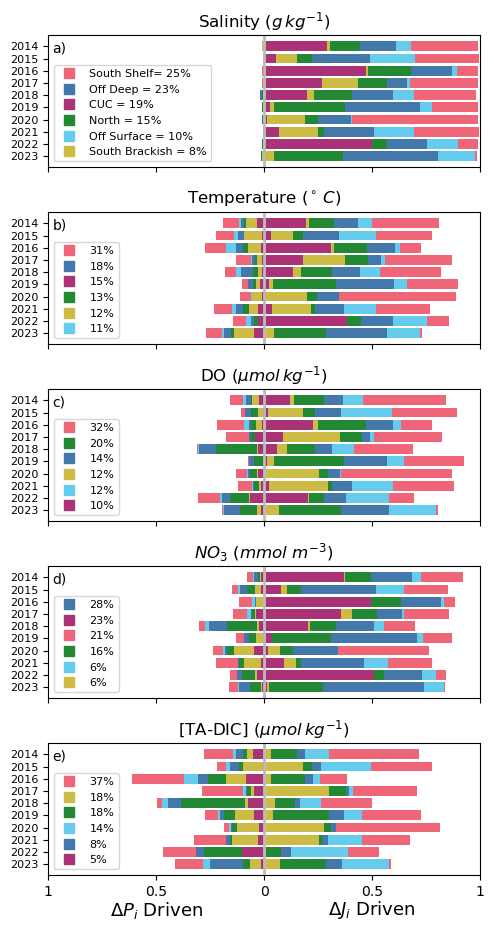

In [ ]:
# with percentage contribution included in the figure 
sections = ['cuc', 'off_d', 'off_s', 'north', 'south', 'fresh']
# Plotting
fig = plt.figure(constrained_layout=True, figsize=[5,9])
gs = GridSpec(5, 1, figure=fig)
ax1 = fig.add_subplot(gs[0,0])
ax3 = fig.add_subplot(gs[1,0])
ax5 = fig.add_subplot(gs[2,0])
ax7 = fig.add_subplot(gs[3,0])
ax9 = fig.add_subplot(gs[4,0])

# SALINITY
df = pd.concat([math_all14[['year','section','saltP','saltQ','saltX']][:-1],math_all15[['year','section','saltP','saltQ','saltX']][:-1],
    math_all16[['year','section','saltP','saltQ','saltX']][:-1],math_all17[['year','section','saltP','saltQ','saltX']][:-1],
    math_all18[['year','section','saltP','saltQ','saltX']][:-1],math_all19[['year','section','saltP','saltQ','saltX']][:-1],
    math_all20[['year','section','saltP','saltQ','saltX']][:-1],math_all21[['year','section','saltP','saltQ','saltX']][:-1],
    math_all22[['year','section','saltP','saltQ','saltX']][:-1],math_all23[['year','section','saltP','saltQ','saltX']][:-1]])
combined_stacked_bar(df,'Salinity (g/kg)',ax1)
ax1.set_title('Salinity ($g\,kg^{-1}$)')
   
df['absP'] = df[df.columns[2]].abs()
df['absQ'] = df[df.columns[3]].abs()
df['absX'] = df[df.columns[4]].abs()
df['total_abs'] = df.groupby('year')[['absP', 'absQ','absX']].transform('sum').sum(axis=1)
df['normP'] = df['absP'] / df['total_abs']
df['normQ'] = df['absQ'] / df['total_abs']
df['normX'] = df['absX'] / df['total_abs']
perc = [int(np.round(np.mean(np.sum([df.normP[df.section==region],df.normQ[df.section==region],df.normX[df.section==region]],axis=0))*100,0)) for region in sections]


legend_handles = []
# 101 - lower north to 15
regions = ['South Shelf= {}%'.format(perc[4]), 'Off Deep = {}%'.format(perc[1]), 'CUC = {}%'.format(perc[0]), 'North = {}%'.format(perc[3]-1),
           'Off Surface = {}%'.format(perc[2]), 'South Brackish = {}%'.format(perc[5])]
colours = ['#EE6677','#4477AA','#AA3377','#228833','#66CCEE','#CCBB44']
for i in range(len(regions)):
    legend_handles.append(mlines.Line2D([], [], 
                          marker='s', linestyle='None',markersize=7,
                          markeredgecolor=colours[i], markerfacecolor=colours[i],
                          label=regions[i]))
# Add a figure-wide legend below the subplots
ax1.legend(handles=legend_handles, loc='lower left', ncol=1, frameon=True,fontsize=8)

# TEMPERATURE
df = pd.concat([math_all14[['year','section','tempP','tempQ','tempX']][:-1],math_all15[['year','section','tempP','tempQ','tempX']][:-1],
    math_all16[['year','section','tempP','tempQ','tempX']][:-1],math_all17[['year','section','tempP','tempQ','tempX']][:-1],
    math_all18[['year','section','tempP','tempQ','tempX']][:-1],math_all19[['year','section','tempP','tempQ','tempX']][:-1],
    math_all20[['year','section','tempP','tempQ','tempX']][:-1],math_all21[['year','section','tempP','tempQ','tempX']][:-1],
    math_all22[['year','section','tempP','tempQ','tempX']][:-1],math_all23[['year','section','tempP','tempQ','tempX']][:-1]])
combined_stacked_bar(df,'Temperature (degC)',ax3)
ax3.set_title('Temperature ($^\circ\,C$)')

df['absP'] = df[df.columns[2]].abs()
df['absQ'] = df[df.columns[3]].abs()
df['absX'] = df[df.columns[4]].abs()
df['total_abs'] = df.groupby('year')[['absP', 'absQ','absX']].transform('sum').sum(axis=1)
df['normP'] = df['absP'] / df['total_abs']
df['normQ'] = df['absQ'] / df['total_abs']
df['normX'] = df['absX'] / df['total_abs']
perc = [int(np.round(np.mean(np.sum([df.normP[df.section==region],df.normQ[df.section==region],df.normX[df.section==region]],axis=0))*100,0)) for region in sections]

legend_handles = []
# 99 - increase offshore surface to 11
regions = ['{}%'.format(perc[4]), '{}%'.format(perc[1]), '{}%'.format(perc[0]),  '{}%'.format(perc[3]),
                   '{}%'.format(perc[5]),  '{}%'.format(perc[2]+1)]
colours = ['#EE6677','#4477AA','#AA3377','#228833','#CCBB44','#66CCEE']
for i in range(len(regions)):
    legend_handles.append(mlines.Line2D([], [], 
                          marker='s', linestyle='None',markersize=7,
                          markeredgecolor=colours[i], markerfacecolor=colours[i],
                          label=regions[i]))
ax3.legend(handles=legend_handles, loc='lower left', ncol=1, frameon=True,fontsize=8)

# DO
df = pd.concat([math_all14[['year','section','DOP','DOQ','DOX']][:-1],math_all15[['year','section','DOP','DOQ','DOX']][:-1],
    math_all16[['year','section','DOP','DOQ','DOX']][:-1],math_all17[['year','section','DOP','DOQ','DOX']][:-1],
    math_all18[['year','section','DOP','DOQ','DOX']][:-1],math_all19[['year','section','DOP','DOQ','DOX']][:-1],
    math_all20[['year','section','DOP','DOQ','DOX']][:-1],math_all21[['year','section','DOP','DOQ','DOX']][:-1],
    math_all22[['year','section','DOP','DOQ','DOX']][:-1],math_all23[['year','section','DOP','DOQ','DOX']][:-1]])
combined_stacked_bar(df,'DO (umol kg-1)',ax5)
ax5.set_title('DO ($\mu mol \, kg^{-1}$)')

df['absP'] = df[df.columns[2]].abs()
df['absQ'] = df[df.columns[3]].abs()
df['absX'] = df[df.columns[4]].abs()
df['total_abs'] = df.groupby('year')[['absP', 'absQ','absX']].transform('sum').sum(axis=1)
df['normP'] = df['absP'] / df['total_abs']
df['normQ'] = df['absQ'] / df['total_abs']
df['normX'] = df['absX'] / df['total_abs']
perc = [int(np.round(np.mean(np.sum([df.normP[df.section==region],df.normQ[df.section==region],df.normX[df.section==region]],axis=0))*100,0)) for region in sections]

legend_handles = []
# 99 - increase north to 20
regions = ['{}%'.format(perc[4]), '{}%'.format(perc[3]+1), '{}%'.format(perc[1]), '{}%'.format(perc[5]),
                   '{}%'.format(perc[2]),  '{}%'.format(perc[0])]
colours = ['#EE6677','#228833','#4477AA','#CCBB44','#66CCEE','#AA3377']
for i in range(len(regions)):
    legend_handles.append(mlines.Line2D([], [], 
                          marker='s', linestyle='None',markersize=7,
                          markeredgecolor=colours[i], markerfacecolor=colours[i],
                          label=regions[i]))
ax5.legend(handles=legend_handles, loc='lower left', ncol=1, frameon=True,fontsize=8)

# NO3
df = pd.concat([math_all14[['year','section','NO3P','NO3Q','NO3X']][:-1],math_all15[['year','section','NO3P','NO3Q','NO3X']][:-1],
    math_all16[['year','section','NO3P','NO3Q','NO3X']][:-1],math_all17[['year','section','NO3P','NO3Q','NO3X']][:-1],
    math_all18[['year','section','NO3P','NO3Q','NO3X']][:-1],math_all19[['year','section','NO3P','NO3Q','NO3X']][:-1],
    math_all20[['year','section','NO3P','NO3Q','NO3X']][:-1],math_all21[['year','section','NO3P','NO3Q','NO3X']][:-1],
    math_all22[['year','section','NO3P','NO3Q','NO3X']][:-1],math_all23[['year','section','NO3P','NO3Q','NO3X']][:-1]])
combined_stacked_bar(df,'NO3 (uM)',ax7)
ax7.set_title('$NO_3$ ($mmol\,\,m^{-3}$)')

df['absP'] = df[df.columns[2]].abs()
df['absQ'] = df[df.columns[3]].abs()
df['absX'] = df[df.columns[4]].abs()
df['total_abs'] = df.groupby('year')[['absP', 'absQ','absX']].transform('sum').sum(axis=1)
df['normP'] = df['absP'] / df['total_abs']
df['normQ'] = df['absQ'] / df['total_abs']
df['normX'] = df['absX'] / df['total_abs']
perc = [int(np.round(np.mean(np.sum([df.normP[df.section==region],df.normQ[df.section==region],df.normX[df.section==region]],axis=0))*100,0)) for region in sections]

legend_handles = []
regions = ['{}%'.format(perc[1]), '{}%'.format(perc[0]), '{}%'.format(perc[4]),
                   '{}%'.format(perc[3]), '{}%'.format(perc[2]), '{}%'.format(perc[5])]
colours = ['#4477AA','#AA3377','#EE6677','#228833','#66CCEE','#CCBB44']
for i in range(len(regions)):
    legend_handles.append(mlines.Line2D([], [], 
                          marker='s', linestyle='None',markersize=7,
                          markeredgecolor=colours[i], markerfacecolor=colours[i],
                          label=regions[i]))
ax7.legend(handles=legend_handles, loc='lower left', ncol=1, frameon=True,fontsize=8)

# TA-DIC
df = pd.concat([math_all14[['year','section','TADICP','TADICQ','TADICX']][:-1],math_all15[['year','section','TADICP','TADICQ','TADICX']][:-1],
    math_all16[['year','section','TADICP','TADICQ','TADICX']][:-1],math_all17[['year','section','TADICP','TADICQ','TADICX']][:-1],
    math_all18[['year','section','TADICP','TADICQ','TADICX']][:-1],math_all19[['year','section','TADICP','TADICQ','TADICX']][:-1],
    math_all20[['year','section','TADICP','TADICQ','TADICX']][:-1],math_all21[['year','section','TADICP','TADICQ','TADICX']][:-1],
    math_all22[['year','section','TADICP','TADICQ','TADICX']][:-1],math_all23[['year','section','TADICP','TADICQ','TADICX']][:-1]])
combined_stacked_bar(df,'[TA-DIC] (uM)',ax9)
ax9.set_title('[TA-DIC] ($\mu mol \, kg^{-1}$)')

df['absP'] = df[df.columns[2]].abs()
df['absQ'] = df[df.columns[3]].abs()
df['absX'] = df[df.columns[4]].abs()
df['total_abs'] = df.groupby('year')[['absP', 'absQ','absX']].transform('sum').sum(axis=1)
df['normP'] = df['absP'] / df['total_abs']
df['normQ'] = df['absQ'] / df['total_abs']
df['normX'] = df['absX'] / df['total_abs']
perc = [int(np.round(np.mean(np.sum([df.normP[df.section==region],df.normQ[df.section==region],df.normX[df.section==region]],axis=0))*100,0)) for region in sections]

legend_handles = []
# 99 - increase south to 37
regions = ['{}%'.format(perc[4]+1), '{}%'.format(perc[5]), '{}%'.format(perc[3]), '{}%'.format(perc[2]),
                   '{}%'.format(perc[1]),  '{}%'.format(perc[0])]
colours = ['#EE6677','#CCBB44','#228833','#66CCEE','#4477AA','#AA3377']
for i in range(len(regions)):
    legend_handles.append(mlines.Line2D([], [], 
                          marker='s', linestyle='None',markersize=7,
                          markeredgecolor=colours[i], markerfacecolor=colours[i],
                          label=regions[i]))
ax9.legend(handles=legend_handles, loc='lower left', ncol=1, frameon=True,fontsize=8)

ax9.set_xticklabels([1,0.5,0,0.5,1]);

# add text to each figure 
ax1.text(.01, .85, 'a)', ha='left', va='bottom', transform=ax1.transAxes, fontsize=10)
ax3.text(.01, .85, 'b)', ha='left', va='bottom', transform=ax3.transAxes, fontsize=10)
ax5.text(.01, .85, 'c)', ha='left', va='bottom', transform=ax5.transAxes, fontsize=10)
ax7.text(.01, .85, 'd)', ha='left', va='bottom', transform=ax7.transAxes, fontsize=10)
ax9.text(.01, .85, 'e)', ha='left', va='bottom', transform=ax9.transAxes, fontsize=10)

ax9.text(.25, -0.35, r'$\Delta P_i$ Driven', ha='center', va='bottom', transform=ax9.transAxes, fontsize=13)
ax9.text(.75, -0.35, r'$\Delta J_i$ Driven', ha='center', va='bottom', transform=ax9.transAxes, fontsize=13)


# plt.savefig("/ocean/rbeutel/MOAD/biogeo_paper/PI_BIOGEO_PAPER/model/figures/attribution_flux.pdf", bbox_inches='tight')

<>:10: SyntaxWarning: invalid escape sequence '\,'
<>:10: SyntaxWarning: invalid escape sequence '\,'
/tmp/ipykernel_3172084/2813863045.py:10: SyntaxWarning: invalid escape sequence '\,'
  combined_stacked_bar(df,'Density ($kg\, m^{-3}$)',ax)


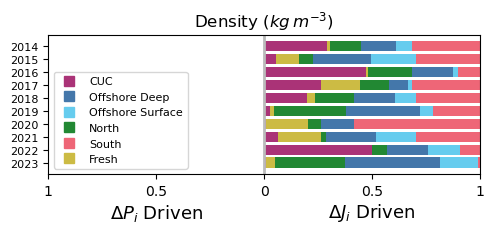

In [ ]:
# just density

fig,ax = plt.subplots(1,1,figsize=[5,2])

df = pd.concat([math_all14[['year','section','densP','densQ']][:-1],math_all15[['year','section','densP','densQ']][:-1],
    math_all16[['year','section','densP','densQ']][:-1],math_all17[['year','section','densP','densQ']][:-1],
    math_all18[['year','section','densP','densQ']][:-1],math_all19[['year','section','densP','densQ']][:-1],
    math_all20[['year','section','densP','densQ']][:-1],math_all21[['year','section','densP','densQ']][:-1],
    math_all22[['year','section','densP','densQ']][:-1],math_all23[['year','section','densP','densQ']][:-1]])
combined_stacked_bar(df,'Density ($kg\, m^{-3}$)',ax)

ax.set_xticklabels([1,0.5,0,0.5,1])
ax.text(.25, -0.35, r'$\Delta P_i$ Driven', ha='center', va='bottom', transform=ax.transAxes, fontsize=13)
ax.text(.75, -0.35, r'$\Delta J_i$ Driven', ha='center', va='bottom', transform=ax.transAxes, fontsize=13)

# # build legend handles    
legend_handles = []
regions = ['CUC', 'Offshore Deep', 'Offshore Surface', 'North', 'South', 'Fresh']
colours = ['#AA3377','#4477AA','#66CCEE','#228833','#EE6677','#CCBB44']
for i in range(len(regions)):
    legend_handles.append(mlines.Line2D([], [], 
                          marker='s', linestyle='None',markersize=7,
                          markeredgecolor=colours[i], markerfacecolor=colours[i],
                          label=regions[i]))
# Add a figure-wide legend below the subplots
ax.legend(handles=legend_handles, loc='lower left', ncol=1, frameon=True,fontsize=8)

# again, very similar to salinity
# plt.savefig('/ocean/rbeutel/MOAD/biogeo_paper/PI_BIOGEO_PAPER/model/figures/attribution_density.jpg',bbox_inches='tight')

In [46]:
# compare salinity and density numbers

# first salinity
df = pd.concat([math_all14[['year','section','saltP','saltQ','saltX']][:-1],math_all15[['year','section','saltP','saltQ','saltX']][:-1],
    math_all16[['year','section','saltP','saltQ','saltX']][:-1],math_all17[['year','section','saltP','saltQ','saltX']][:-1],
    math_all18[['year','section','saltP','saltQ','saltX']][:-1],math_all19[['year','section','saltP','saltQ','saltX']][:-1],
    math_all20[['year','section','saltP','saltQ','saltX']][:-1],math_all21[['year','section','saltP','saltQ','saltX']][:-1],
    math_all22[['year','section','saltP','saltQ','saltX']][:-1],math_all23[['year','section','saltP','saltQ','saltX']][:-1]])

# Calculate absolute values
df['absP'] = df[df.columns[2]].abs()
df['absQ'] = df[df.columns[3]].abs()

# Normalize the data within each year
df['total_abs'] = df.groupby('year')[['absP', 'absQ']].transform('sum').sum(axis=1)
df['normP'] = df['absP'] / df['total_abs']
df['normQ'] = df['absQ'] / df['total_abs']

# Aggregate normalized values by year and section
agg_df = df.groupby(['year', 'section'])[['normP', 'normQ']].sum().reset_index()

# Pivot the DataFrame for plotting
saltP = agg_df.pivot(index='year', columns='section', values='normP').fillna(0)
saltQ = agg_df.pivot(index='year', columns='section', values='normQ').fillna(0)


# Density
df = pd.concat([math_all14[['year','section','densP','densQ']][:-1],math_all15[['year','section','densP','densQ']][:-1],
    math_all16[['year','section','densP','densQ']][:-1],math_all17[['year','section','densP','densQ']][:-1],
    math_all18[['year','section','densP','densQ']][:-1],math_all19[['year','section','densP','densQ']][:-1],
    math_all20[['year','section','densP','densQ']][:-1],math_all21[['year','section','densP','densQ']][:-1],
    math_all22[['year','section','densP','densQ']][:-1],math_all23[['year','section','densP','densQ']][:-1]])

# Calculate absolute values
df['absP'] = df[df.columns[2]].abs()
df['absQ'] = df[df.columns[3]].abs()

# Normalize the data within each year
df['total_abs'] = df.groupby('year')[['absP', 'absQ']].transform('sum').sum(axis=1)
df['normP'] = df['absP'] / df['total_abs']
df['normQ'] = df['absQ'] / df['total_abs']

# Aggregate normalized values by year and section
agg_df = df.groupby(['year', 'section'])[['normP', 'normQ']].sum().reset_index()

# Pivot the DataFrame for plotting
densP = agg_df.pivot(index='year', columns='section', values='normP').fillna(0)
densQ = agg_df.pivot(index='year', columns='section', values='normQ').fillna(0)

In [51]:
saltP

section,cuc,fresh,north,off_d,off_s,south
year,,,,,,
2014,0.000168,0.008073,0.000850,0.000795,0.000173,0.000490
2015,0.000303,0.002879,0.002282,0.000953,0.000369,0.000025
2016,0.001246,0.000769,0.002122,0.000230,0.000700,0.002411
2017,0.001034,0.004142,0.000799,0.000110,0.000957,0.001226
2018,0.000272,0.004802,0.005844,0.005824,0.002215,0.000546
2019,0.001071,0.004078,0.002361,0.001391,0.000239,0.000532
2020,0.001656,0.005662,0.002006,0.000641,0.000194,0.000259
2021,0.000453,0.000703,0.001715,0.000089,0.000505,0.001068
2022,0.001252,0.002019,0.004341,0.001592,0.000638,0.001177


In [48]:
densP

section,cuc,fresh,north,off_d,off_s,south
year,,,,,,
2014,0.000128,0.000129,0.000010,0.000007,0.000008,0.000168
2015,0.000040,0.000078,0.000131,0.000087,0.000044,0.000156
2016,0.000135,0.000113,0.000031,0.000047,0.000105,0.000242
2017,0.000013,0.000137,0.000027,0.000054,0.000020,0.000168
2018,0.000119,0.000078,0.000271,0.000314,0.000091,0.000131
2019,0.000146,0.000079,0.000110,0.000138,0.000011,0.000028
2020,0.000091,0.000215,0.000102,0.000098,0.000019,0.000044
2021,0.000097,0.000068,0.000032,0.000153,0.000032,0.000159
2022,0.000007,0.000049,0.000199,0.000093,0.000012,0.000164


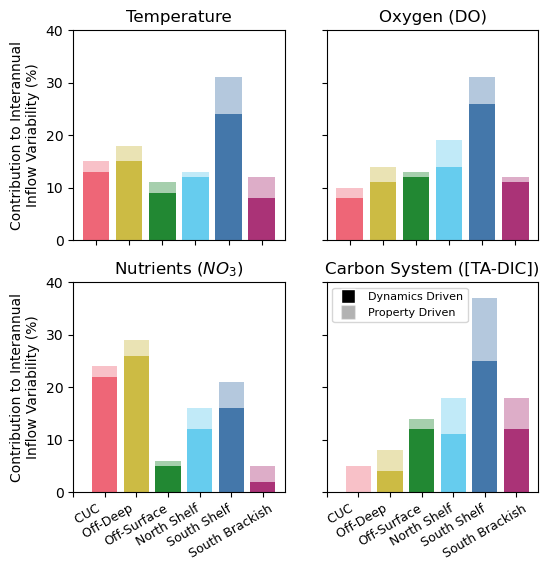

In [49]:
# for key figure

  

fig, ax = plt.subplots(2,2,figsize=(6,6))

# temperature 
df = pd.concat([math_all14[['year','section','tempP','tempQ','tempX']][:-1],math_all15[['year','section','tempP','tempQ','tempX']][:-1],
    math_all16[['year','section','tempP','tempQ','tempX']][:-1],math_all17[['year','section','tempP','tempQ','tempX']][:-1],
    math_all18[['year','section','tempP','tempQ','tempX']][:-1],math_all19[['year','section','tempP','tempQ','tempX']][:-1],
    math_all20[['year','section','tempP','tempQ','tempX']][:-1],math_all21[['year','section','tempP','tempQ','tempX']][:-1],
    math_all22[['year','section','tempP','tempQ','tempX']][:-1],math_all23[['year','section','tempP','tempQ','tempX']][:-1]])

df['absP'] = df[df.columns[2]].abs()
df['absQ'] = df[df.columns[3]].abs()
df['total_abs'] = df.groupby('year')[['absP', 'absQ']].transform('sum').sum(axis=1)
df['normP'] = df['absP'] / df['total_abs']
df['normQ'] = df['absQ'] / df['total_abs']
percQ = [int(np.round(np.mean(df.normQ[df.section==region],axis=0),2)*100) for region in sections]
percP = [int(np.round(np.mean(df.normP[df.section==region],axis=0),2)*100) for region in sections]

ax[0,0].bar(range(len(sections)),percQ,color=colours)
ax[0,0].bar(range(len(sections)),percP,color=colours,bottom=percQ,alpha=0.4)
ax[0,0].set_xticks(range(len(sections)))
ax[0,0].set_xticklabels([])
ax[0,0].set_yticks(np.arange(0,41,10))
ax[0,0].set_title("Temperature")


# DO 
df = pd.concat([math_all14[['year','section','DOP','DOQ','DOX']][:-1],math_all15[['year','section','DOP','DOQ','DOX']][:-1],
    math_all16[['year','section','DOP','DOQ','DOX']][:-1],math_all17[['year','section','DOP','DOQ','DOX']][:-1],
    math_all18[['year','section','DOP','DOQ','DOX']][:-1],math_all19[['year','section','DOP','DOQ','DOX']][:-1],
    math_all20[['year','section','DOP','DOQ','DOX']][:-1],math_all21[['year','section','DOP','DOQ','DOX']][:-1],
    math_all22[['year','section','DOP','DOQ','DOX']][:-1],math_all23[['year','section','DOP','DOQ','DOX']][:-1]])

df['absP'] = df[df.columns[2]].abs()
df['absQ'] = df[df.columns[3]].abs()
df['total_abs'] = df.groupby('year')[['absP', 'absQ']].transform('sum').sum(axis=1)
df['normP'] = df['absP'] / df['total_abs']
df['normQ'] = df['absQ'] / df['total_abs']
percQ = [int(np.round(np.mean(df.normQ[df.section==region],axis=0),2)*100) for region in sections]
percP = [int(np.round(np.mean(df.normP[df.section==region],axis=0),2)*100) for region in sections]

ax[0,1].bar(range(len(sections)),percQ,color=colours)
ax[0,1].bar(range(len(sections)),percP,color=colours,bottom=percQ,alpha=0.4)
ax[0,1].set_xticks(range(len(sections)))
ax[0,1].set_xticklabels([])
ax[0,1].set_yticks(np.arange(0,41,10))
ax[0,1].set_yticklabels([])
ax[0,1].set_title("Oxygen (DO)")


# NO3 
df = pd.concat([math_all14[['year','section','NO3P','NO3Q','NO3X']][:-1],math_all15[['year','section','NO3P','NO3Q','NO3X']][:-1],
    math_all16[['year','section','NO3P','NO3Q','NO3X']][:-1],math_all17[['year','section','NO3P','NO3Q','NO3X']][:-1],
    math_all18[['year','section','NO3P','NO3Q','NO3X']][:-1],math_all19[['year','section','NO3P','NO3Q','NO3X']][:-1],
    math_all20[['year','section','NO3P','NO3Q','NO3X']][:-1],math_all21[['year','section','NO3P','NO3Q','NO3X']][:-1],
    math_all22[['year','section','NO3P','NO3Q','NO3X']][:-1],math_all23[['year','section','NO3P','NO3Q','NO3X']][:-1]])

df['absP'] = df[df.columns[2]].abs()
df['absQ'] = df[df.columns[3]].abs()
df['total_abs'] = df.groupby('year')[['absP', 'absQ']].transform('sum').sum(axis=1)
df['normP'] = df['absP'] / df['total_abs']
df['normQ'] = df['absQ'] / df['total_abs']
percQ = [int(np.round(np.mean(df.normQ[df.section==region],axis=0),2)*100) for region in sections]
percP = [int(np.round(np.mean(df.normP[df.section==region],axis=0),2)*100) for region in sections]

ax[1,0].bar(range(len(sections)),percQ,color=colours)
ax[1,0].bar(range(len(sections)),percP,color=colours,bottom=percQ,alpha=0.4)
ax[1,0].set_xticks(np.array(range(len(sections)+1))-1)
ax[1,0].set_xticklabels(['        CUC','  Off-Deep','Off-Surface','North Shelf','South Shelf','South Brackish',''],rotation=30,fontsize=9)
ax[1,0].set_yticks(np.arange(0,41,10))
ax[1,0].set_title("Nutrients ($NO_3$)")


# TADIC 
df = pd.concat([math_all14[['year','section','TADICP','TADICQ','TADICX']][:-1],math_all15[['year','section','TADICP','TADICQ','TADICX']][:-1],
    math_all16[['year','section','TADICP','TADICQ','TADICX']][:-1],math_all17[['year','section','TADICP','TADICQ','TADICX']][:-1],
    math_all18[['year','section','TADICP','TADICQ','TADICX']][:-1],math_all19[['year','section','TADICP','TADICQ','TADICX']][:-1],
    math_all20[['year','section','TADICP','TADICQ','TADICX']][:-1],math_all21[['year','section','TADICP','TADICQ','TADICX']][:-1],
    math_all22[['year','section','TADICP','TADICQ','TADICX']][:-1],math_all23[['year','section','TADICP','TADICQ','TADICX']][:-1]])

df['absP'] = df[df.columns[2]].abs()
df['absQ'] = df[df.columns[3]].abs()
df['total_abs'] = df.groupby('year')[['absP', 'absQ']].transform('sum').sum(axis=1)
df['normP'] = df['absP'] / df['total_abs']
df['normQ'] = df['absQ'] / df['total_abs']
percQ = [int(np.round(np.mean(df.normQ[df.section==region],axis=0),2)*100) for region in sections]
percP = [int(np.round(np.mean(df.normP[df.section==region],axis=0),2)*100) for region in sections]

ax[1,1].bar(range(len(sections)),percQ,color=colours)
ax[1,1].bar(range(len(sections)),percP,color=colours,bottom=percQ,alpha=0.4)
ax[1,1].set_xticks(np.array(range(len(sections)+1))-1)
ax[1,1].set_xticklabels(['        CUC','  Off-Deep','Off-Surface','North Shelf','South Shelf','South Brackish',''],rotation=30,fontsize=9)
ax[1,1].set_yticks(np.arange(0,41,10))
ax[1,1].set_yticklabels([])
ax[1,1].set_title("Carbon System ([TA-DIC])")



# formatting for all
ymax = 40
ax[0,0].set_ylim([0,ymax])
ax[0,1].set_ylim([0,ymax])
ax[1,0].set_ylim([0,ymax])
ax[1,1].set_ylim([0,ymax])

ax[0,0].set_ylabel('Contribution to Interannual\nInflow Variability (%)')
ax[1,0].set_ylabel('Contribution to Interannual\nInflow Variability (%)')


# add legend
legend_handles = []
alphas = [1,0.3]
labels = ['Dynamics Driven','Property Driven']
for i in range(len(alphas)):
    legend_handles.append(mlines.Line2D([], [], 
                          marker='s', linestyle='None',markersize=10,
                          markeredgecolor='w', markerfacecolor='k',
                          label=labels[i],alpha=alphas[i]))
ax[1,1].legend(handles=legend_handles, loc='best', ncol=1, frameon=True,fontsize=8)

# plt.savefig("/data1/bbeutel/LO_user/ariane/figures/keyfigurebars.jpg", bbox_inches='tight')

### with loop

<>:25: SyntaxWarning: invalid escape sequence '\c'
<>:33: SyntaxWarning: invalid escape sequence '\m'
<>:41: SyntaxWarning: invalid escape sequence '\,'
<>:49: SyntaxWarning: invalid escape sequence '\m'
<>:25: SyntaxWarning: invalid escape sequence '\c'
<>:33: SyntaxWarning: invalid escape sequence '\m'
<>:41: SyntaxWarning: invalid escape sequence '\,'
<>:49: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_3172084/3816587411.py:25: SyntaxWarning: invalid escape sequence '\c'
  combined_stacked_bar_LOOP(df,'Temperature ($^\circ C$)',ax3)
/tmp/ipykernel_3172084/3816587411.py:33: SyntaxWarning: invalid escape sequence '\m'
  combined_stacked_bar_LOOP(df,'DO ($\mu mol \, kg^{-1}$)',ax5)
/tmp/ipykernel_3172084/3816587411.py:41: SyntaxWarning: invalid escape sequence '\,'
  combined_stacked_bar_LOOP(df,'NO3 ($mmol \, m^{-3}$)',ax7)
/tmp/ipykernel_3172084/3816587411.py:49: SyntaxWarning: invalid escape sequence '\m'
  combined_stacked_bar_LOOP(df,'[TA-DIC] ($\mu mol \, kg^{-1}$)'

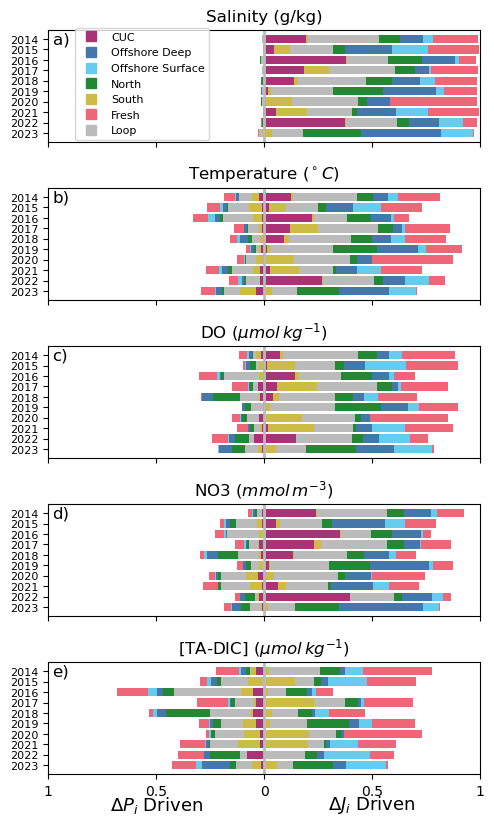

In [91]:
# without subfigures to the right
# Plotting
fig = plt.figure(constrained_layout=True, figsize=[5,8])
gs = GridSpec(5, 1, figure=fig)
ax1 = fig.add_subplot(gs[0,0])
ax3 = fig.add_subplot(gs[1,0])
ax5 = fig.add_subplot(gs[2,0])
ax7 = fig.add_subplot(gs[3,0])
ax9 = fig.add_subplot(gs[4,0])

# SALINITY
df = pd.concat([math_all14[['year','section','saltP','saltQ']],math_all15[['year','section','saltP','saltQ']],
    math_all16[['year','section','saltP','saltQ']],math_all17[['year','section','saltP','saltQ']],
    math_all18[['year','section','saltP','saltQ']],math_all19[['year','section','saltP','saltQ']],
    math_all20[['year','section','saltP','saltQ']],math_all21[['year','section','saltP','saltQ']],
    math_all22[['year','section','saltP','saltQ']],math_all23[['year','section','saltP','saltQ']]])
combined_stacked_bar_LOOP(df,'Salinity (g/kg)',ax1)

# TEMPERATURE
df = pd.concat([math_all14[['year','section','tempP','tempQ']],math_all15[['year','section','tempP','tempQ']],
    math_all16[['year','section','tempP','tempQ']],math_all17[['year','section','tempP','tempQ']],
    math_all18[['year','section','tempP','tempQ']],math_all19[['year','section','tempP','tempQ']],
    math_all20[['year','section','tempP','tempQ']],math_all21[['year','section','tempP','tempQ']],
    math_all22[['year','section','tempP','tempQ']],math_all23[['year','section','tempP','tempQ']]])
combined_stacked_bar_LOOP(df,'Temperature ($^\circ C$)',ax3)

# DO
df = pd.concat([math_all14[['year','section','DOP','DOQ']],math_all15[['year','section','DOP','DOQ']],
    math_all16[['year','section','DOP','DOQ']],math_all17[['year','section','DOP','DOQ']],
    math_all18[['year','section','DOP','DOQ']],math_all19[['year','section','DOP','DOQ']],
    math_all20[['year','section','DOP','DOQ']],math_all21[['year','section','DOP','DOQ']],
    math_all22[['year','section','DOP','DOQ']],math_all23[['year','section','DOP','DOQ']]])
combined_stacked_bar_LOOP(df,'DO ($\mu mol \, kg^{-1}$)',ax5)

# NO3
df = pd.concat([math_all14[['year','section','NO3P','NO3Q']],math_all15[['year','section','NO3P','NO3Q']],
    math_all16[['year','section','NO3P','NO3Q']],math_all17[['year','section','NO3P','NO3Q']],
    math_all18[['year','section','NO3P','NO3Q']],math_all19[['year','section','NO3P','NO3Q']],
    math_all20[['year','section','NO3P','NO3Q']],math_all21[['year','section','NO3P','NO3Q']],
    math_all22[['year','section','NO3P','NO3Q']],math_all23[['year','section','NO3P','NO3Q']]])
combined_stacked_bar_LOOP(df,'NO3 ($mmol \, m^{-3}$)',ax7)

# TA-DIC
df = pd.concat([math_all14[['year','section','TADICP','TADICQ']],math_all15[['year','section','TADICP','TADICQ']],
    math_all16[['year','section','TADICP','TADICQ']],math_all17[['year','section','TADICP','TADICQ']],
    math_all18[['year','section','TADICP','TADICQ']],math_all19[['year','section','TADICP','TADICQ']],
    math_all20[['year','section','TADICP','TADICQ']],math_all21[['year','section','TADICP','TADICQ']],
    math_all22[['year','section','TADICP','TADICQ']],math_all23[['year','section','TADICP','TADICQ']]])
combined_stacked_bar_LOOP(df,'[TA-DIC] ($\mu mol \, kg^{-1}$)',ax9)

ax9.set_xticklabels([1,0.5,0,0.5,1]);

# add text to each figure 
ax1.text(.01, .85, 'a)', ha='left', va='bottom', transform=ax1.transAxes, fontsize=12)
ax3.text(.01, .85, 'b)', ha='left', va='bottom', transform=ax3.transAxes, fontsize=12)
ax5.text(.01, .85, 'c)', ha='left', va='bottom', transform=ax5.transAxes, fontsize=12)
ax7.text(.01, .85, 'd)', ha='left', va='bottom', transform=ax7.transAxes, fontsize=12)
ax9.text(.01, .85, 'e)', ha='left', va='bottom', transform=ax9.transAxes, fontsize=12)

ax9.text(.25, -0.36, r'$\Delta P_i$ Driven', ha='center', va='bottom', transform=ax9.transAxes, fontsize=13)
ax9.text(.75, -0.36, r'$\Delta J_i$ Driven', ha='center', va='bottom', transform=ax9.transAxes, fontsize=13)

# # build legend handles    
legend_handles = []
regions = ['CUC', 'Offshore Deep', 'Offshore Surface', 'North', 'South', 'Fresh','Loop']
colours = ['#AA3377','#4477AA','#66CCEE','#228833','#CCBB44','#EE6677','#BBBBBB']
for i in range(len(regions)):
    legend_handles.append(mlines.Line2D([], [], 
                          marker='s', linestyle='None',markersize=7,
                          markeredgecolor=colours[i], markerfacecolor=colours[i],
                          label=regions[i]))
# Add a figure-wide legend below the subplots
ax1.legend(handles=legend_handles, bbox_to_anchor=(0.05, -0.03), loc='lower left', ncol=1, frameon=True,fontsize=8)

plt.savefig("/ocean/rbeutel/MOAD/biogeo_paper/PI_BIOGEO_PAPER/model/figures/attribution_flux_loop.pdf", bbox_inches='tight')

### upwelling downwelling

In [54]:
# fix [TA-DIC] columns
up14['[TA-DIC]'] = up14.TA-up14.DIC
up15['[TA-DIC]'] = up15.TA-up15.DIC
up16['[TA-DIC]'] = up16.TA-up16.DIC
up17['[TA-DIC]'] = up17.TA-up17.DIC
up18['[TA-DIC]'] = up18.TA-up18.DIC
up19['[TA-DIC]'] = up19.TA-up19.DIC
up20['[TA-DIC]'] = up20.TA-up20.DIC
up21['[TA-DIC]'] = up21.TA-up21.DIC
up22['[TA-DIC]'] = up22.TA-up22.DIC
up23['[TA-DIC]'] = up23.TA-up23.DIC

dw13['[TA-DIC]'] = dw13.TA-dw13.DIC
dw14['[TA-DIC]'] = dw14.TA-dw14.DIC
dw15['[TA-DIC]'] = dw15.TA-dw15.DIC
dw16['[TA-DIC]'] = dw16.TA-dw16.DIC
dw17['[TA-DIC]'] = dw17.TA-dw17.DIC
dw18['[TA-DIC]'] = dw18.TA-dw18.DIC
dw19['[TA-DIC]'] = dw19.TA-dw19.DIC
dw20['[TA-DIC]'] = dw20.TA-dw20.DIC
dw21['[TA-DIC]'] = dw21.TA-dw21.DIC
dw22['[TA-DIC]'] = dw22.TA-dw22.DIC


In [63]:
# make 'baseline' dataframe based on the means of all the data
d = {'section':['salish','cuc', 'off_d', 'off_s', 'north', 'south', 'fresh','loop'],
     'transport':np.mean([up14.transport,up15.transport,up16.transport,up17.transport,
                          up18.transport,up19.transport, up20.transport,up21.transport,
                          up22.transport,up23.transport],axis=0),
     'salt':np.mean([up15.salt,up16.salt,up17.salt,up18.salt,up19.salt,up20.salt,up21.salt,up22.salt,up23.salt],axis=0),
     'temp':np.mean([up14.temp,up15.temp,up16.temp,up17.temp,up18.temp,up19.temp,up20.temp,up21.temp,up22.temp,up23.temp],axis=0),
     'DO':np.mean([up14.DO,up15.DO,up16.DO,up17.DO,up18.DO,up19.DO,up20.DO,up21.DO,up22.DO,up23.DO],axis=0),
     'NO3':np.mean([up14.NO3,up15.NO3,up16.NO3,up17.NO3,up18.NO3,up19.NO3,up20.NO3,up21.NO3,up22.NO3,up23.NO3],axis=0),
     'density':np.mean([up14.density,up15.density,up16.density,up17.density,up18.density,up19.density,up20.density,up21.density,up22.density,up23.density],axis=0),
     '[TA-DIC]':np.mean([up14['[TA-DIC]'],up15['[TA-DIC]'],up16['[TA-DIC]'],up17['[TA-DIC]'],up18['[TA-DIC]'],up19['[TA-DIC]'],up20['[TA-DIC]'],up21['[TA-DIC]'],up22['[TA-DIC]'],up23['[TA-DIC]']],axis=0)}
up_b = pd.DataFrame(d)

up_b

,section,transport,salt,temp,DO,NO3,density,[TA-DIC]
0,salish,2.865845e+07,33.502675,7.058725,85.834066,32.753155,1026.639037,3.070564
1,cuc,6.737156e+06,33.901629,6.259874,62.262945,37.274650,1027.805412,-0.756599
2,off_d,6.601797e+06,33.749448,6.616534,88.595468,33.794378,1027.442330,15.386482
3,off_s,1.265449e+06,32.896968,8.440819,214.562520,16.544396,1025.801668,106.417751
4,north,5.529095e+06,33.238695,7.548266,153.255783,24.258695,1026.395323,59.706935
5,south,9.764585e+05,32.979054,8.920014,200.763872,19.094953,1025.815510,94.077571
6,fresh,2.112832e+05,29.832321,10.541815,306.807291,5.786466,1022.601861,181.723609
7,loop,7.337206e+06,32.114080,8.817403,159.222735,28.583153,1024.948564,37.452876


In [65]:
# math!
math_up14 = decomp(up14,up_b)[1:]
math_up15 = decomp(up15,up_b)[1:]
math_up16 = decomp(up16,up_b)[1:]
math_up17 = decomp(up17,up_b)[1:]
math_up18 = decomp(up18,up_b)[1:]
math_up19 = decomp(up19,up_b)[1:]
math_up20 = decomp(up20,up_b)[1:]
math_up21 = decomp(up21,up_b)[1:]
math_up22 = decomp(up22,up_b)[1:]
math_up23 = decomp(up23,up_b)[1:]

# add year 
math_up14['year'] = 2014
math_up15['year'] = 2015
math_up16['year'] = 2016
math_up17['year'] = 2017
math_up18['year'] = 2018
math_up19['year'] = 2019
math_up20['year'] = 2020
math_up21['year'] = 2021
math_up22['year'] = 2022
math_up23['year'] = 2023

In [62]:
# make 'baseline' dataframe based on the means of all the data
d = {'section':['salish','cuc', 'off_d', 'off_s', 'north', 'south', 'fresh','loop'],
     'transport':np.mean([dw13.transport,dw14.transport,dw15.transport,dw16.transport,dw17.transport,dw18.transport,
                          dw19.transport,dw20.transport,dw21.transport,dw22.transport],axis=0),
     'salt':np.mean([dw13.salt,dw14.salt,dw15.salt,dw16.salt,dw17.salt,dw18.salt,dw19.salt,dw20.salt,dw21.salt,dw22.salt],axis=0),
     'temp':np.mean([dw13.temp,dw14.temp,dw15.temp,dw16.temp,dw17.temp,dw18.temp,dw19.temp,dw20.temp,dw21.temp,dw22.temp],axis=0),
     'DO':np.mean([dw13.DO,dw14.DO,dw15.DO,dw16.DO,dw17.DO,dw18.DO,dw19.DO,dw20.DO,dw21.DO,dw22.DO],axis=0),
     'NO3':np.mean([dw13.NO3,dw14.NO3,dw15.NO3,dw16.NO3,dw17.NO3,dw18.NO3,dw19.NO3,dw20.NO3,dw21.NO3,dw22.NO3],axis=0),
     'density':np.mean([dw13.density,dw14.density,dw15.density,dw16.density,dw17.density,dw18.density,dw19.density,dw20.density,dw21.density,dw22.density],axis=0),
     '[TA-DIC]':np.mean([dw13['[TA-DIC]'],dw14['[TA-DIC]'],dw15['[TA-DIC]'],dw16['[TA-DIC]'],dw17['[TA-DIC]'],dw18['[TA-DIC]'],dw19['[TA-DIC]'],dw20['[TA-DIC]'],dw21['[TA-DIC]'],dw22['[TA-DIC]']],axis=0)}
dw_b = pd.DataFrame(d)

dw_b

,section,transport,salt,temp,DO,NO3,density,[TA-DIC]
0,salish,1.908892e+07,32.237827,8.508770,178.519055,23.391358,1025.380790,63.614511
1,cuc,2.671836e+06,33.742330,6.963555,74.114319,35.175855,1027.351072,-1.222486
2,off_d,6.227095e+05,33.621582,6.993844,97.836059,32.141572,1027.125113,18.028756
3,off_s,5.711955e+05,32.724662,9.660364,217.290233,13.468248,1025.402099,122.284778
4,north,1.979996e+05,32.771191,9.212934,193.807149,17.139795,1025.498598,95.787968
5,south,4.797785e+06,32.826371,9.545874,196.776244,17.670007,1025.546252,94.967875
6,fresh,2.985310e+06,30.240506,10.016067,289.855536,7.857657,1023.157586,165.812709
7,loop,7.242081e+06,31.884531,8.321166,187.129456,26.569484,1025.013004,47.842467


In [64]:
# math! 
math_dw13 = decomp(dw13,dw_b)[1:]
math_dw15 = decomp(dw15,dw_b)[1:]
math_dw14 = decomp(dw14,dw_b)[1:]
math_dw16 = decomp(dw16,dw_b)[1:]
math_dw17 = decomp(dw17,dw_b)[1:]
math_dw18 = decomp(dw18,dw_b)[1:]
math_dw19 = decomp(dw19,dw_b)[1:]
math_dw20 = decomp(dw20,dw_b)[1:]
math_dw21 = decomp(dw21,dw_b)[1:]
math_dw22 = decomp(dw22,dw_b)[1:]

# add year 
math_dw13['year'] = 2013
math_dw14['year'] = 2014
math_dw15['year'] = 2015
math_dw16['year'] = 2016
math_dw17['year'] = 2017
math_dw18['year'] = 2018
math_dw19['year'] = 2019
math_dw20['year'] = 2020
math_dw21['year'] = 2021
math_dw22['year'] = 2022

<>:101: SyntaxWarning: invalid escape sequence '\,'
<>:102: SyntaxWarning: invalid escape sequence '\c'
<>:103: SyntaxWarning: invalid escape sequence '\m'
<>:104: SyntaxWarning: invalid escape sequence '\,'
<>:105: SyntaxWarning: invalid escape sequence '\m'
<>:101: SyntaxWarning: invalid escape sequence '\,'
<>:102: SyntaxWarning: invalid escape sequence '\c'
<>:103: SyntaxWarning: invalid escape sequence '\m'
<>:104: SyntaxWarning: invalid escape sequence '\,'
<>:105: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_3172084/2212528406.py:101: SyntaxWarning: invalid escape sequence '\,'
  ax[0,0].set_ylabel('Salinity ($g\,kg^{-1}$)',fontsize=11)
/tmp/ipykernel_3172084/2212528406.py:102: SyntaxWarning: invalid escape sequence '\c'
  ax[1,0].set_ylabel('Temperature ($^\circ C$)',fontsize=11)
/tmp/ipykernel_3172084/2212528406.py:103: SyntaxWarning: invalid escape sequence '\m'
  ax[2,0].set_ylabel('DO ($\mu mol\, kg^{-1}$)',fontsize=11)
/tmp/ipykernel_3172084/2212528406.py:104

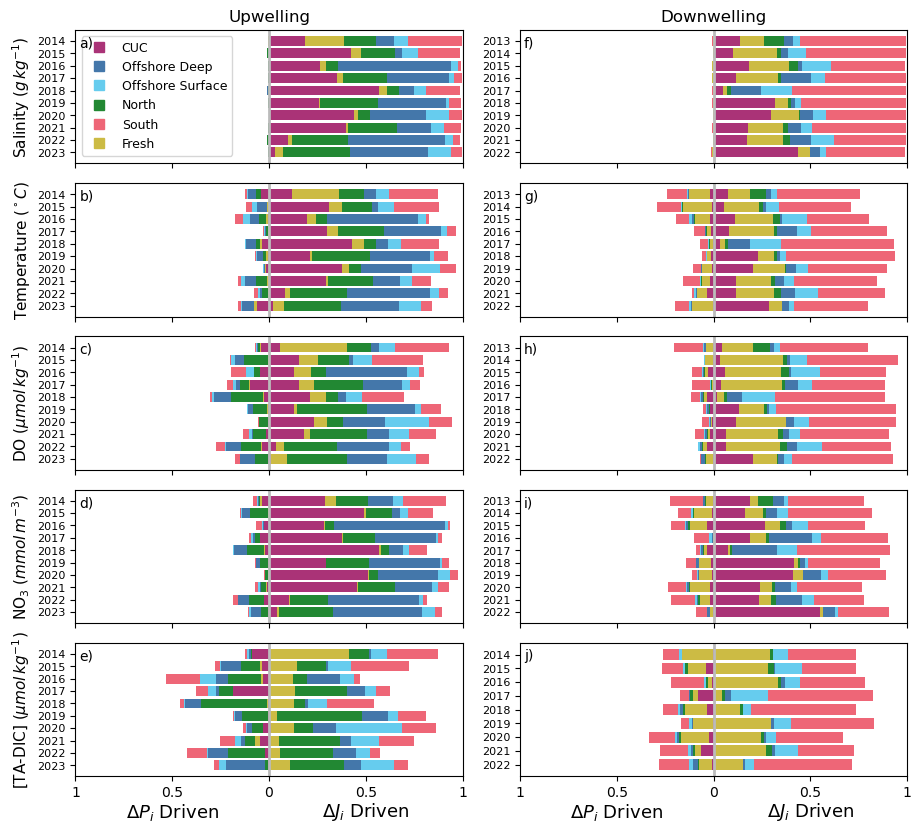

In [84]:
fig, ax = plt.subplots(5,2,figsize=[9,8])

#############
# UPWELLING #
#############
# SALINITY
df = pd.concat([math_up14[['year','section','saltP','saltQ']][:-1],math_up15[['year','section','saltP','saltQ']][:-1],
    math_up16[['year','section','saltP','saltQ']][:-1],math_up17[['year','section','saltP','saltQ']][:-1],
    math_up18[['year','section','saltP','saltQ']][:-1],math_up19[['year','section','saltP','saltQ']][:-1],
    math_up20[['year','section','saltP','saltQ']][:-1],math_up21[['year','section','saltP','saltQ']][:-1],
    math_up22[['year','section','saltP','saltQ']][:-1],math_up23[['year','section','saltP','saltQ']][:-1]])
combined_stacked_bar(df,'',ax[0,0])

# TEMPERATURE
df = pd.concat([math_up14[['year','section','tempP','tempQ']][:-1],math_up15[['year','section','tempP','tempQ']][:-1],
    math_up16[['year','section','tempP','tempQ']][:-1],math_up17[['year','section','tempP','tempQ']][:-1],
    math_up18[['year','section','tempP','tempQ']][:-1],math_up19[['year','section','tempP','tempQ']][:-1],
    math_up20[['year','section','tempP','tempQ']][:-1],math_up21[['year','section','tempP','tempQ']][:-1],
    math_up22[['year','section','tempP','tempQ']][:-1],math_up23[['year','section','tempP','tempQ']][:-1]])
combined_stacked_bar(df,'',ax[1,0])

# DO
df = pd.concat([math_up14[['year','section','DOP','DOQ']][:-1],math_up15[['year','section','DOP','DOQ']][:-1],
    math_up16[['year','section','DOP','DOQ']][:-1],math_up17[['year','section','DOP','DOQ']][:-1],
    math_up18[['year','section','DOP','DOQ']][:-1],math_up19[['year','section','DOP','DOQ']][:-1],
    math_up20[['year','section','DOP','DOQ']][:-1],math_up21[['year','section','DOP','DOQ']][:-1],
    math_up22[['year','section','DOP','DOQ']][:-1],math_up23[['year','section','DOP','DOQ']][:-1]])
combined_stacked_bar(df,'',ax[2,0])

# NO3
df = pd.concat([math_up14[['year','section','NO3P','NO3Q']][:-1],math_up15[['year','section','NO3P','NO3Q']][:-1],
    math_up16[['year','section','NO3P','NO3Q']][:-1],math_up17[['year','section','NO3P','NO3Q']][:-1],
    math_up18[['year','section','NO3P','NO3Q']][:-1],math_up19[['year','section','NO3P','NO3Q']][:-1],
    math_up20[['year','section','NO3P','NO3Q']][:-1],math_up21[['year','section','NO3P','NO3Q']][:-1],
    math_up22[['year','section','NO3P','NO3Q']][:-1],math_up23[['year','section','NO3P','NO3Q']][:-1],])
combined_stacked_bar(df,'',ax[3,0])

# TA-DIC
df = pd.concat([math_up14[['year','section','TADICP','TADICQ']][:-1],math_up15[['year','section','TADICP','TADICQ']][:-1],
    math_up16[['year','section','TADICP','TADICQ']][:-1],math_up17[['year','section','TADICP','TADICQ']][:-1],
    math_up18[['year','section','TADICP','TADICQ']][:-1],math_up19[['year','section','TADICP','TADICQ']][:-1],
    math_up20[['year','section','TADICP','TADICQ']][:-1],math_up21[['year','section','TADICP','TADICQ']][:-1],
    math_up22[['year','section','TADICP','TADICQ']][:-1],math_up23[['year','section','TADICP','TADICQ']][:-1]])
combined_stacked_bar(df,'',ax[4,0])

ax[4,0].set_xticklabels([1,0.5,0,0.5,1]);

###############
# DOWNWELLING #
###############

# SALINITY
df = pd.concat([math_dw13[['year','section','saltP','saltQ']][:-1],math_dw14[['year','section','saltP','saltQ']][:-1],
    math_dw15[['year','section','saltP','saltQ']][:-1],math_dw16[['year','section','saltP','saltQ']][:-1],
    math_dw17[['year','section','saltP','saltQ']][:-1],math_dw18[['year','section','saltP','saltQ']][:-1],
    math_dw19[['year','section','saltP','saltQ']][:-1],math_dw20[['year','section','saltP','saltQ']][:-1],
    math_dw21[['year','section','saltP','saltQ']][:-1],math_dw22[['year','section','saltP','saltQ']][:-1]])
combined_stacked_bar(df,'',ax[0,1])

# TEMPERATURE
df = pd.concat([math_dw13[['year','section','tempP','tempQ']][:-1],math_dw14[['year','section','tempP','tempQ']][:-1],
    math_dw15[['year','section','tempP','tempQ']][:-1],math_dw16[['year','section','tempP','tempQ']][:-1],
    math_dw17[['year','section','tempP','tempQ']][:-1],math_dw18[['year','section','tempP','tempQ']][:-1],
    math_dw19[['year','section','tempP','tempQ']][:-1],math_dw20[['year','section','tempP','tempQ']][:-1],
    math_dw21[['year','section','tempP','tempQ']][:-1],math_dw22[['year','section','tempP','tempQ']][:-1]])
combined_stacked_bar(df,'',ax[1,1])

# DO
df = pd.concat([math_dw13[['year','section','DOP','DOQ']][:-1],math_dw14[['year','section','DOP','DOQ']][:-1],
    math_dw15[['year','section','DOP','DOQ']][:-1],math_dw16[['year','section','DOP','DOQ']][:-1],
    math_dw17[['year','section','DOP','DOQ']][:-1],math_dw18[['year','section','DOP','DOQ']][:-1],
    math_dw19[['year','section','DOP','DOQ']][:-1],math_dw20[['year','section','DOP','DOQ']][:-1],
    math_dw21[['year','section','DOP','DOQ']][:-1],math_dw22[['year','section','DOP','DOQ']][:-1]])
combined_stacked_bar(df,'',ax[2,1])

# NO3
df = pd.concat([math_dw13[['year','section','NO3P','NO3Q']][:-1],math_dw14[['year','section','NO3P','NO3Q']][:-1],
    math_dw15[['year','section','NO3P','NO3Q']][:-1],math_dw16[['year','section','NO3P','NO3Q']][:-1],
    math_dw17[['year','section','NO3P','NO3Q']][:-1],math_dw18[['year','section','NO3P','NO3Q']][:-1],
    math_dw19[['year','section','NO3P','NO3Q']][:-1],math_dw20[['year','section','NO3P','NO3Q']][:-1],
    math_dw21[['year','section','NO3P','NO3Q']][:-1],math_dw22[['year','section','NO3P','NO3Q']][:-1],])
combined_stacked_bar(df,'',ax[3,1])

# TA-DIC
df = pd.concat([math_dw14[['year','section','TADICP','TADICQ']][:-1],math_dw15[['year','section','TADICP','TADICQ']][:-1],
    math_dw16[['year','section','TADICP','TADICQ']][:-1],math_dw17[['year','section','TADICP','TADICQ']][:-1],
    math_dw18[['year','section','TADICP','TADICQ']][:-1],math_dw19[['year','section','TADICP','TADICQ']][:-1],
    math_dw20[['year','section','TADICP','TADICQ']][:-1],math_dw21[['year','section','TADICP','TADICQ']][:-1],
    math_dw22[['year','section','TADICP','TADICQ']][:-1]])
combined_stacked_bar(df,'',ax[4,1])

ax[4,1].set_xticklabels([1,0.5,0,0.5,1]);

##############
# FORMATTING #
##############

ax[0,0].set_title('Upwelling')
ax[0,1].set_title('Downwelling')

ax[0,0].set_ylabel('Salinity ($g\,kg^{-1}$)',fontsize=11)
ax[1,0].set_ylabel('Temperature ($^\circ C$)',fontsize=11)
ax[2,0].set_ylabel('DO ($\mu mol\, kg^{-1}$)',fontsize=11)
ax[3,0].set_ylabel('NO$_3$ ($mmol\, m^{-3}$)',fontsize=11)
ax[4,0].set_ylabel('[TA-DIC] ($\mu mol \, kg^{-1}$)',fontsize=11)

# # build legend handles    
legend_handles = []
regions = ['CUC', 'Offshore Deep', 'Offshore Surface', 'North', 'South', 'Fresh']
colours = ['#AA3377','#4477AA','#66CCEE','#228833','#EE6677','#CCBB44']
for i in range(len(regions)):
    legend_handles.append(mlines.Line2D([], [], 
                          marker='s', linestyle='None',markersize=7,
                          markeredgecolor=colours[i], markerfacecolor=colours[i],
                          label=regions[i]))
ax[0,0].legend(handles=legend_handles, loc='best', ncol=1, frameon=True,fontsize=9)

# add text to each figure 
ax[0,0].text(.01, .85, 'a)', ha='left', va='bottom', transform=ax[0,0].transAxes, fontsize=10,zorder=6)
ax[1,0].text(.01, .85, 'b)', ha='left', va='bottom', transform=ax[1,0].transAxes, fontsize=10)
ax[2,0].text(.01, .85, 'c)', ha='left', va='bottom', transform=ax[2,0].transAxes, fontsize=10)
ax[3,0].text(.01, .85, 'd)', ha='left', va='bottom', transform=ax[3,0].transAxes, fontsize=10)
ax[4,0].text(.01, .85, 'e)', ha='left', va='bottom', transform=ax[4,0].transAxes, fontsize=10)

ax[0,1].text(.01, .85, 'f)', ha='left', va='bottom', transform=ax[0,1].transAxes, fontsize=10)
ax[1,1].text(.01, .85, 'g)', ha='left', va='bottom', transform=ax[1,1].transAxes, fontsize=10)
ax[2,1].text(.01, .85, 'h)', ha='left', va='bottom', transform=ax[2,1].transAxes, fontsize=10)
ax[3,1].text(.01, .85, 'i)', ha='left', va='bottom', transform=ax[3,1].transAxes, fontsize=10)
ax[4,1].text(.01, .85, 'j)', ha='left', va='bottom', transform=ax[4,1].transAxes, fontsize=10)


ax[4,0].text(.25, -0.35, r'$\Delta P_i$ Driven', ha='center', va='bottom', transform=ax[4,0].transAxes, fontsize=13)
ax[4,0].text(.75, -0.35, r'$\Delta J_i$ Driven', ha='center', va='bottom', transform=ax[4,0].transAxes, fontsize=13)
ax[4,1].text(.25, -0.35, r'$\Delta P_i$ Driven', ha='center', va='bottom', transform=ax[4,1].transAxes, fontsize=13)
ax[4,1].text(.75, -0.35, r'$\Delta J_i$ Driven', ha='center', va='bottom', transform=ax[4,1].transAxes, fontsize=13)


plt.savefig('/ocean/rbeutel/MOAD/biogeo_paper/PI_BIOGEO_PAPER/model/figures/updown_attribution.jpg', bbox_inches='tight')
